# Urban Heat Island (UHI) Benchmark Notebook 

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [1]:
# Suppress Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Core Data Science
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial Data Processing
import rioxarray as rxr
import rasterio

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Machine Learning - Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Model Persistence
import joblib

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("../data/Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul> 
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image. 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

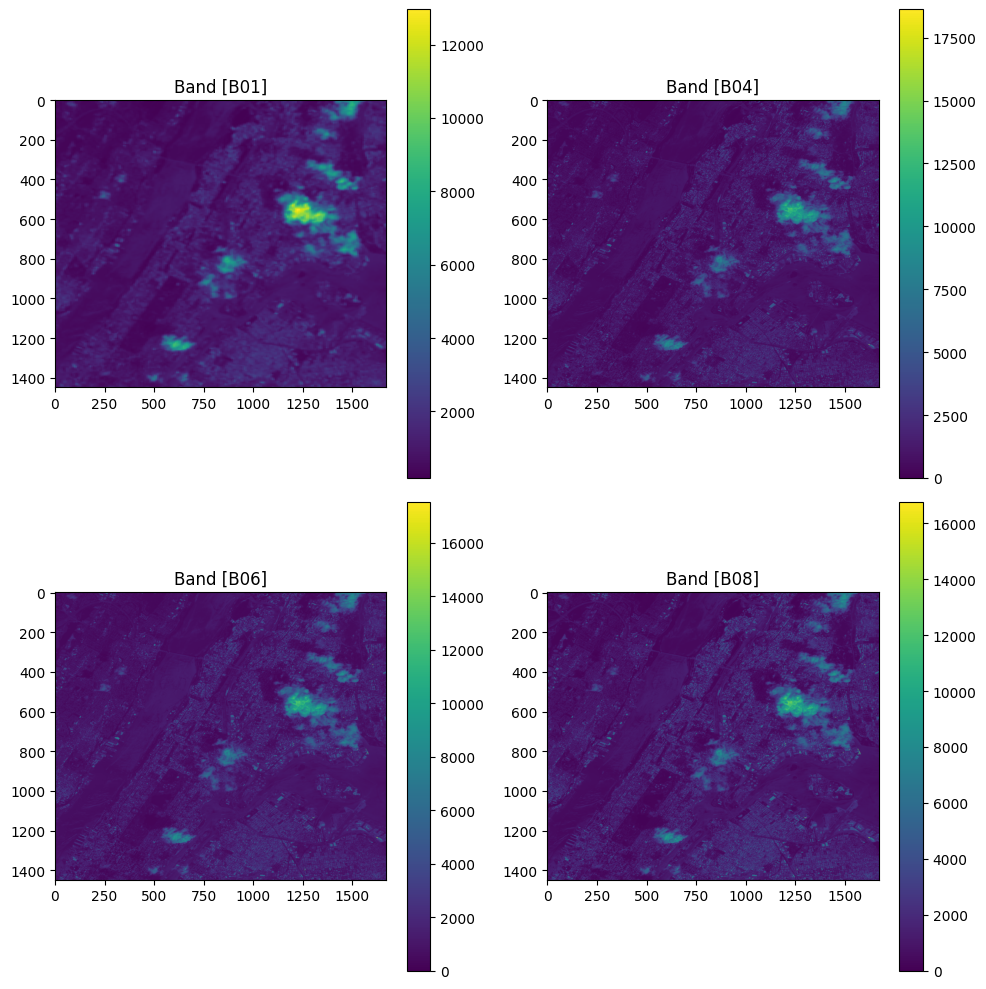

In [3]:
# Open the GeoTIFF file
tiff_path = "../data/S2_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [4]:
def map_satellite_data_with_buffer(tiff_path, csv_path, buffer_radius=700, 
                                  weighting='gaussian', land_cover_mask=None, 
                                  outlier_threshold=3, min_valid_pixels=5,
                                  adaptive_weighting=False, drop_invalid=True,
                                  handle_out_of_bounds='nearest'):
    """
    Extracts satellite band values from a GeoTIFF based on coordinates from a csv file,
    using advanced buffer techniques with customizable weighting schemes.
    
    Parameters:
    tiff_path (str): Path to the GeoTIFF file
    csv_path (str): Path to the CSV file containing coordinates
    buffer_radius (float): Radius in meters for the buffer zone (default: 700)
    weighting (str): Weighting method to use - options:
                    'uniform' - equal weight to all pixels (simple average)
                    'gaussian' - gaussian distance weighting (default)
                    'inverse' - inverse distance weighting
                    'triangular' - linear decrease with distance
    land_cover_mask (str): Optional path to land cover raster for masking (e.g., to exclude water pixels)
    outlier_threshold (float): Standard deviation threshold for outlier removal (default: 3)
    min_valid_pixels (int): Minimum number of valid pixels required (default: 5)
    adaptive_weighting (bool): If True, selects best weighting method for each point based on local variance (default: False)
    drop_invalid (bool): If True, drops points that are outside raster bounds or have NaN values (default: True)
    handle_out_of_bounds (str): How to handle points outside raster bounds:
                               'drop' - drop these points
                               'nearest' - use nearest valid pixel values
                               'knn' - use k-nearest neighbor interpolation from valid points
    
    Returns:
    pd.DataFrame: DataFrame containing processed band values for each input location with metadata
    """
    # Load the GeoTIFF data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = rxr.open_rasterio(tiff_path)
    
    # Load land cover mask if provided
    if land_cover_mask is not None:
        try:
            lc_data = rxr.open_rasterio(land_cover_mask)
        except Exception as e:
            print(f"Warning: Could not load land cover mask: {e}")
            land_cover_mask = None
    
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    # Make sure latitude and longitude columns exist
    required_cols = ['Latitude', 'Longitude']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"CSV must contain {', '.join(required_cols)} columns")
    
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Calculate buffer size in pixels (assuming 10m resolution)
    buffer_pixels = int(np.ceil(buffer_radius / 10))
    
    # Identify band names from the raster data
    if hasattr(data, 'band_names') and data.band_names:
        band_names = data.band_names
    else:
        # Default Sentinel-2 band names
        band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 
                      'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
        if data.shape[0] != len(band_names):
            band_names = [f'Band_{i+1}' for i in range(data.shape[0])]
    
    # Initialize dictionary for band values and metadata
    result_dict = {band_name: [] for band_name in band_names}
    metadata = {
        'Latitude': [], 'Longitude': [], 
        'buffer_radius_m': [], 'pixels_used': [],
        'weighting': [], 'stddev': [], 'outliers_removed': []
    }

    # Get the affine transform from the data
    transform = data.rio.transform()
    resolution = data.rio.resolution()[0]  # Assuming square pixels
    
    # Define weighting function
    def get_weights(distances, method, radius):
        # Handle empty array
        if len(distances) == 0:
            return np.array([])
            
        if method == 'uniform':
            return np.ones_like(distances)
        elif method == 'gaussian':
            # Gaussian with sigma = radius/3 (so most weight is within radius)
            sigma = radius / 3
            return np.exp(-(distances**2) / (2 * sigma**2))
        elif method == 'inverse':
            # Add small epsilon to avoid division by zero
            return 1 / (distances + 0.1)
        elif method == 'triangular':
            # Linear decrease with distance
            return np.maximum(0, 1 - distances/radius)
        else:
            # Default to uniform if unknown method
            warnings.warn(f"Unknown weighting method: {method}, using uniform instead")
            return np.ones_like(distances)
    
    # Prepare for adaptive weighting
    weighting_methods = ['uniform', 'gaussian', 'inverse', 'triangular'] if adaptive_weighting else [weighting]
    
    # Collect all valid and invalid points for potential interpolation
    valid_points = []
    invalid_indices = []
    
    # Iterate over the latitudes and longitudes
    invalid_points = 0
    for idx, (lat, lon) in enumerate(tqdm(zip(latitudes, longitudes), 
                                         total=len(latitudes), 
                                         desc="Processing locations")):
        # Convert lat/lon to pixel coordinates
        col, row = ~transform * (lon, lat)
        row, col = int(row), int(col)
        
        # Check if point is within raster bounds
        if (row < 0 or row >= data.rio.width or 
            col < 0 or col >= data.rio.height):
            invalid_points += 1
            invalid_indices.append(idx)
            
            # For invalid points, we'll handle them based on the chosen method
            if handle_out_of_bounds == 'drop':
                # Fill with NaN (original behavior)
                for band_name in band_names:
                    result_dict[band_name].append(np.nan)
                # Add metadata
                metadata['Latitude'].append(lat)
                metadata['Longitude'].append(lon)
                metadata['buffer_radius_m'].append(buffer_radius)
                metadata['pixels_used'].append(np.nan)
                metadata['weighting'].append(weighting)
                metadata['stddev'].append(np.nan)
                metadata['outliers_removed'].append(np.nan)
                continue
            else:
                # For 'nearest' and 'knn' methods, add placeholders temporarily
                for band_name in band_names:
                    result_dict[band_name].append(None)  # Placeholder to maintain index
                # Add metadata
                metadata['Latitude'].append(lat)
                metadata['Longitude'].append(lon)
                metadata['buffer_radius_m'].append(buffer_radius)
                metadata['pixels_used'].append(0)
                metadata['weighting'].append(weighting)
                metadata['stddev'].append(np.nan)
                metadata['outliers_removed'].append(0)
                continue
        
        # Keep track of valid points for potential interpolation
        valid_points.append((idx, lat, lon, row, col))
        
        # Calculate window bounds with padding to handle edge cases
        row_start = max(0, row - buffer_pixels)
        row_end = min(data.rio.width, row + buffer_pixels + 1)
        col_start = max(0, col - buffer_pixels)
        col_end = min(data.rio.height, col + buffer_pixels + 1)
        
        # Create a grid of pixel coordinates for the window
        y_indices, x_indices = np.indices((col_end - col_start, row_end - row_start))
        y_coords = y_indices + col_start
        x_coords = x_indices + row_start
        
        # Calculate distances from center point (in meters)
        distances = np.sqrt((x_coords - row)**2 + (y_coords - col)**2) * resolution
        
        # Create mask for pixels within buffer radius
        distance_mask = distances <= buffer_radius
        
        # Apply land cover mask if provided
        if land_cover_mask is not None:
            try:
                lc_window = lc_data[0, col_start:col_end, row_start:row_end].values
                # Assuming water classes are 0 or 1 (modify as needed for your land cover data)
                water_mask = ~np.isin(lc_window, [0, 1])
                combined_mask = distance_mask & water_mask
            except Exception:
                combined_mask = distance_mask
        else:
            combined_mask = distance_mask
        
        # Implement adaptive weighting if requested
        if adaptive_weighting:            
            # Get a sample band to analyze local characteristics
            sample_band_idx = min(3, len(band_names) - 1)  # Use band ~4 if available (good middle ground)
            sample_window = data[sample_band_idx, col_start:col_end, row_start:row_end].values
            valid_pixels = sample_window[distance_mask & ~np.isnan(sample_window)]
            
            # Skip adaptive weighting if not enough valid pixels
            if len(valid_pixels) < min_valid_pixels * 2:
                # Fall back to specified weighting method
                weighting_methods = [weighting]
            else:
                # Calculate metrics to determine best weighting method
                window_mean = np.mean(valid_pixels)
                window_cv = np.std(valid_pixels) / (window_mean + 1e-10)  # Coefficient of variation
                
                edge_values = sample_window[((x_coords == row_start) | (x_coords == row_end - 1) | 
                                           (y_coords == col_start) | (y_coords == col_end - 1)) & 
                                          distance_mask & ~np.isnan(sample_window)]
                center_values = sample_window[((x_coords - row)**2 + (y_coords - col)**2 <= (buffer_pixels/3)**2) & 
                                            ~np.isnan(sample_window)]
                
                # Calculate center-to-edge gradient 
                edge_mean = np.mean(edge_values) if len(edge_values) > 0 else window_mean
                center_mean = np.mean(center_values) if len(center_values) > 0 else window_mean
                gradient = abs(center_mean - edge_mean) / (window_mean + 1e-10)
                
                # Select weighting method based on local characteristics
                if gradient > 0.3:  # Strong center-to-edge gradient
                    # Strong gradient suggests gaussian or inverse weighting
                    weighting_methods = ['gaussian', 'inverse']
                elif window_cv < 0.1:  # Low variation
                    # Low variation suggests uniform weighting
                    weighting_methods = ['uniform']
                elif window_cv > 0.3:  # High variation
                    # High variation suggests triangular or gaussian (balance)
                    weighting_methods = ['triangular', 'gaussian']
                # Otherwise test all methods
        
        # Process each band
        point_metadata = {
            'pixels_used': 0,
            'stddev': [],
            'outliers_removed': 0,
            'selected_weighting': weighting
        }
        
        # Store results for each weighting method if adaptive weighting is used
        if len(weighting_methods) > 1:
            weighting_results = {method: {} for method in weighting_methods}
        
        for band_idx, band_name in enumerate(band_names):
            # Get the band data for the window
            try:
                window_data = data[band_idx, col_start:col_end, row_start:row_end].values
            except IndexError:
                # Handle case where band index doesn't match data dimensions
                result_dict[band_name].append(np.nan)
                continue
                
            # Apply mask and get valid values
            valid_mask = combined_mask & ~np.isnan(window_data)
            valid_values = window_data[valid_mask]
            valid_weights = get_weights(distances[valid_mask], weighting_methods[0], buffer_radius)
            
            # Skip if no valid values
            if len(valid_values) < min_valid_pixels:
                if len(weighting_methods) > 1:
                    for method in weighting_methods:
                        if band_name not in weighting_results[method]:
                            weighting_results[method][band_name] = np.nan
                else:
                    result_dict[band_name].append(np.nan)
                continue
                
            # Store initial number of pixels
            initial_pixels = len(valid_values)
            
            # Remove outliers if requested and if we have enough data points
            if outlier_threshold is not None and len(valid_values) > 10:
                mean = np.mean(valid_values)
                std = np.std(valid_values)
                if std > 0:  # Only filter if there's actually variation
                    outlier_mask = np.abs(valid_values - mean) <= (outlier_threshold * std)
                    
                    # Update values and weights
                    valid_values = valid_values[outlier_mask]
                    valid_weights = valid_weights[outlier_mask]
                    outliers_removed = initial_pixels - len(valid_values)
                    point_metadata['outliers_removed'] = outliers_removed
            
            # Calculate weighted average
            if len(valid_values) > 0:
                # If testing multiple weighting methods
                if len(weighting_methods) > 1:
                    # Store results for each method
                    for method in weighting_methods:
                        method_weights = get_weights(distances[valid_mask], method, buffer_radius)
                        # Ensure weights and values have the same shape
                        if len(method_weights) != len(valid_values):
                            # Reshape weights to match values
                            if len(valid_values) < len(method_weights):
                                method_weights = method_weights[:len(valid_values)]
                            else:
                                # Pad weights if necessary (shouldn't happen in normal cases)
                                pad_length = len(valid_values) - len(method_weights)
                                method_weights = np.pad(method_weights, (0, pad_length), 'constant', constant_values=(0,))
                        
                        # Normalize weights (ensure they sum to 1)
                        if np.sum(method_weights) > 0:
                            method_weights = method_weights / np.sum(method_weights)
                        else:
                            method_weights = np.ones_like(valid_values) / len(valid_values)
                            
                        # Calculate weighted average
                        weighted_avg = np.sum(valid_values * method_weights)
                        std_dev = np.std(valid_values)
                        
                        # Store in temporary dictionary
                        if band_name not in weighting_results[method]:
                            weighting_results[method][band_name] = weighted_avg
                            weighting_results[method]['stddev'] = [std_dev]
                        else:
                            weighting_results[method]['stddev'].append(std_dev)
                else:
                    # Single weighting method (standard case)
                    # Normalize weights
                    valid_weights = valid_weights / np.sum(valid_weights)
                    weighted_avg = np.sum(valid_values * valid_weights)
                    std_dev = np.std(valid_values)
                    
                    result_dict[band_name].append(weighted_avg)
                    point_metadata['pixels_used'] = len(valid_values)
                    point_metadata['stddev'].append(std_dev)
            else:
                # Fallback to center pixel if no valid values in buffer
                try:
                    center_value = data[band_idx, col, row].values
                    center_value_float = float(center_value)
                    
                    if len(weighting_methods) > 1:
                        for method in weighting_methods:
                            if band_name not in weighting_results[method]:
                                weighting_results[method][band_name] = center_value_float
                    else:
                        result_dict[band_name].append(center_value_float)
                except:
                    if len(weighting_methods) > 1:
                        for method in weighting_methods:
                            if band_name not in weighting_results[method]:
                                weighting_results[method][band_name] = np.nan
                    else:
                        result_dict[band_name].append(np.nan)
        
        # If using adaptive weighting, select the best method
        if len(weighting_methods) > 1:
            # Criteria for selecting best weighting method:
            # 1. Lowest coefficient of variation of spectral indices (if we have enough bands)
            # 2. Balance between spatial smoothness and feature preservation
            
            method_scores = {}
            for method in weighting_methods:
                # Calculate mean and variance across bands
                band_values = [val for key, val in weighting_results[method].items() 
                              if key not in ['stddev'] and not np.isnan(val)]
                
                if len(band_values) >= 3:  # Need at least a few bands for a meaningful analysis
                    # Calculate coefficient of variation (lower is better for stability)
                    cv = np.std(band_values) / (np.mean(np.abs(band_values)) + 1e-10)
                    
                    # Calculate average standard deviation (lower is better for noise reduction)
                    avg_stddev = np.mean(weighting_results[method].get('stddev', [0]))
                    
                    # Score based on balance between CV and stddev
                    # We prefer methods that balance smoothness (low stddev) with feature preservation (not too low CV)
                    score = -cv * 0.4 - (avg_stddev / (np.mean(np.abs(band_values)) + 1e-10)) * 0.6
                    method_scores[method] = score
            
            # Select best method (highest score)
            if method_scores:
                best_method = max(method_scores.items(), key=lambda x: x[1])[0]
                point_metadata['selected_weighting'] = best_method
                
                # Add the values from best method to result
                for band_name in band_names:
                    if band_name in weighting_results[best_method]:
                        result_dict[band_name].append(weighting_results[best_method][band_name])
                
                # Update metadata
                if 'stddev' in weighting_results[best_method]:
                    point_metadata['stddev'] = np.mean(weighting_results[best_method]['stddev'])
                else:
                    point_metadata['stddev'] = np.nan
            else:
                # If no valid scores, use default weighting
                best_method = weighting
                point_metadata['selected_weighting'] = best_method
                
                # Add results using default method
                for band_name in band_names:
                    if band_name in weighting_results[best_method]:
                        result_dict[band_name].append(weighting_results[best_method][band_name])
        
        # Calculate average standard deviation across bands
        if point_metadata['stddev'] and not isinstance(point_metadata['stddev'], float):
            point_metadata['stddev'] = np.mean(point_metadata['stddev'])
            
        # Add metadata
        metadata['Latitude'].append(lat)
        metadata['Longitude'].append(lon)
        metadata['buffer_radius_m'].append(buffer_radius)
        metadata['pixels_used'].append(point_metadata['pixels_used'])
        metadata['weighting'].append(point_metadata['selected_weighting'])
        metadata['stddev'].append(point_metadata['stddev'])
        metadata['outliers_removed'].append(point_metadata['outliers_removed'])
    
    # Handle out-of-bounds points after processing valid ones
    if handle_out_of_bounds in ['nearest', 'knn'] and invalid_points > 0 and valid_points:
        print(f"Interpolating values for {invalid_points} out-of-bounds points...")
        
        # Need to import required libraries here for interpolation
        if handle_out_of_bounds == 'nearest':
            from scipy.spatial import cKDTree
        elif handle_out_of_bounds == 'knn':
            from sklearn.neighbors import KNeighborsRegressor
        
        # Extract valid lat/lon for interpolation
        valid_indices = [p[0] for p in valid_points]
        valid_lats = [p[1] for p in valid_points]
        valid_lons = [p[2] for p in valid_points]
        
        # For each band, interpolate values for invalid points
        for band_name in band_names:
            # Skip if this band wasn't processed for valid points
            if not all(isinstance(result_dict[band_name][i], (int, float)) for i in valid_indices):
                continue
                
            valid_values = [result_dict[band_name][i] for i in valid_indices 
                           if isinstance(result_dict[band_name][i], (int, float))]
            valid_coords = np.column_stack(([valid_lats[i] for i in range(len(valid_indices)) 
                                          if isinstance(result_dict[band_name][valid_indices[i]], (int, float))],
                                          [valid_lons[i] for i in range(len(valid_indices)) 
                                          if isinstance(result_dict[band_name][valid_indices[i]], (int, float))]))
            
            if len(valid_values) == 0 or len(valid_coords) == 0:
                continue
                
            if handle_out_of_bounds == 'nearest':
                # For each invalid point, find the nearest valid point
                # Build KD-tree with valid points
                tree = cKDTree(valid_coords)
                
                # For each invalid point
                for idx in invalid_indices:
                    invalid_lat = latitudes[idx]
                    invalid_lon = longitudes[idx]
                    
                    # Find nearest neighbor
                    dist, nn_idx = tree.query([invalid_lat, invalid_lon], k=1)
                    
                    # Use the value from nearest neighbor
                    result_dict[band_name][idx] = valid_values[nn_idx]
                    
                    # Update metadata to indicate this is an interpolated value
                    metadata['weighting'][idx] = f"nearest_interpolated_{weighting}"
                    metadata['pixels_used'][idx] = 1
            
            elif handle_out_of_bounds == 'knn':
                # K-nearest neighbors interpolation
                # Create and fit KNN model
                k = min(5, len(valid_coords))  # Use at most 5 neighbors
                knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
                knn.fit(valid_coords, valid_values)
                
                # Interpolate for invalid points
                invalid_coords = np.column_stack(([latitudes[i] for i in invalid_indices],
                                                 [longitudes[i] for i in invalid_indices]))
                
                interpolated_values = knn.predict(invalid_coords)
                
                # Assign interpolated values
                for i, idx in enumerate(invalid_indices):
                    result_dict[band_name][idx] = interpolated_values[i]
                    
                    # Update metadata to indicate this is an interpolated value
                    metadata['weighting'][idx] = f"knn{k}_interpolated_{weighting}"
                    metadata['pixels_used'][idx] = k

    if invalid_points > 0:
        if handle_out_of_bounds == 'drop':
            print(f"Warning: {invalid_points} points were outside the raster bounds.")
        else:
            print(f"Handled {invalid_points} out-of-bounds points using '{handle_out_of_bounds}' method.")
    
    # Create results DataFrame
    result_df = pd.DataFrame(result_dict)
    
    # Add metadata columns
    for key, values in metadata.items():
        result_df[key] = values
    
    # Add derived spectral indices relevant for urban heat island studies
    try:
        # Reference band names for Sentinel-2
        band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
        available_bands = [band for band in band_names if band in result_df.columns]
        
        # Add a tiny constant to prevent division by zero
        epsilon = 1e-10
        
        # BASIC BAND RATIOS - Simple but powerful features
        # Iterate through all possible band combinations to create ratios
        for i, band1 in enumerate(available_bands):
            for j, band2 in enumerate(available_bands):
                if i < j:  # Avoid duplicates and self-ratios
                    ratio_name = f"{band1}_{band2}_ratio"
                    result_df[ratio_name] = result_df[band1] / (result_df[band2] + epsilon)
        
        # VEGETATION INDICES
        # NDVI - Normalized Difference Vegetation Index
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            result_df['NDVI'] = (result_df['B08'] - result_df['B04']) / (result_df['B08'] + result_df['B04'] + epsilon)
        
        # EVI - Enhanced Vegetation Index (reduces atmospheric and soil background influences)
        if all(band in result_df.columns for band in ['B02', 'B04', 'B08']):
            result_df['EVI'] = 2.5 * ((result_df['B08'] - result_df['B04']) / 
                                    (result_df['B08'] + 6 * result_df['B04'] - 7.5 * result_df['B02'] + 1 + epsilon))
        
        # SAVI - Soil Adjusted Vegetation Index (L=0.5 typically)
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            L = 0.5  # Soil brightness correction factor
            result_df['SAVI'] = ((result_df['B08'] - result_df['B04']) / 
                            (result_df['B08'] + result_df['B04'] + L + epsilon)) * (1 + L)
        
        # MSAVI2 - Modified Soil Adjusted Vegetation Index
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            NIR = result_df['B08']
            RED = result_df['B04']
            result_df['MSAVI'] = (2 * NIR + 1 - np.sqrt((2 * NIR + 1)**2 - 8 * (NIR - RED))) / 2
        
        # ARVI - Atmospherically Resistant Vegetation Index
        if all(band in result_df.columns for band in ['B02', 'B04', 'B08']):
            # Using blue band (B02) to correct for atmospheric scattering
            RB = result_df['B04'] - (result_df['B02'] - result_df['B04'])  # Red - (Blue - Red)
            result_df['ARVI'] = (result_df['B08'] - RB) / (result_df['B08'] + RB + epsilon)
        
        # GNDVI - Green Normalized Difference Vegetation Index
        if 'B08' in result_df.columns and 'B03' in result_df.columns:
            result_df['GNDVI'] = (result_df['B08'] - result_df['B03']) / (result_df['B08'] + result_df['B03'] + epsilon)
        
        # RVI - Ratio Vegetation Index (simple but effective)
        if 'B08' in result_df.columns and 'B04' in result_df.columns:
            result_df['RVI'] = result_df['B08'] / (result_df['B04'] + epsilon)
        
        # WATER INDICES
        # NDWI - Normalized Difference Water Index (Green-NIR)
        if 'B03' in result_df.columns and 'B08' in result_df.columns:
            result_df['NDWI'] = (result_df['B03'] - result_df['B08']) / (result_df['B03'] + result_df['B08'] + epsilon)
        
        # MNDWI - Modified NDWI (Green-SWIR)
        if 'B03' in result_df.columns and 'B11' in result_df.columns:
            result_df['MNDWI'] = (result_df['B03'] - result_df['B11']) / (result_df['B03'] + result_df['B11'] + epsilon)
        
        # WRI - Water Ratio Index
        if all(band in result_df.columns for band in ['B03', 'B04', 'B08', 'B11']):
            result_df['WRI'] = (result_df['B03'] + result_df['B04']) / (result_df['B08'] + result_df['B11'] + epsilon)
        
        # AWEI - Automated Water Extraction Index
        if all(band in result_df.columns for band in ['B02', 'B03', 'B08', 'B11', 'B12']):
            result_df['AWEI'] = 4 * (result_df['B03'] - result_df['B11']) - (0.25 * result_df['B08'] + 2.75 * result_df['B12'])
        
        # BUILT-UP/URBAN INDICES
        # NDBI - Normalized Difference Built-up Index
        if 'B08' in result_df.columns and 'B11' in result_df.columns:
            result_df['NDBI'] = (result_df['B11'] - result_df['B08']) / (result_df['B11'] + result_df['B08'] + epsilon)
        
        # BUI - Built-Up Index (combination of NDBI and NDVI)
        if 'NDBI' in result_df.columns and 'NDVI' in result_df.columns:
            result_df['BUI'] = result_df['NDBI'] - result_df['NDVI']
        
        # UI - Urban Index
        if 'B07' in result_df.columns and 'B04' in result_df.columns:
            result_df['UI'] = (result_df['B07'] - result_df['B04']) / (result_df['B07'] + result_df['B04'] + epsilon)
        
        # NDBaI - Normalized Difference Bareness Index
        if 'B11' in result_df.columns and 'B12' in result_df.columns:
            result_df['NDBaI'] = (result_df['B11'] - result_df['B12']) / (result_df['B11'] + result_df['B12'] + epsilon)
        
        # THERMAL/HEAT RELATED INDICES
        # NBDI - Normalized Difference Bareness Index (different from NDBaI)
        if 'B11' in result_df.columns and 'B08' in result_df.columns:
            result_df['NBDI'] = (result_df['B11'] - result_df['B08']) / (result_df['B11'] + result_df['B08'] + epsilon)
        
        # BSI - Bare Soil Index
        if all(band in result_df.columns for band in ['B02', 'B04', 'B08', 'B11']):
            result_df['BSI'] = ((result_df['B04'] + result_df['B11']) - (result_df['B08'] + result_df['B02'])) / \
                            ((result_df['B04'] + result_df['B11']) + (result_df['B08'] + result_df['B02']) + epsilon)
        
        # IBI - Index-based Built-up Index
        if all(ind in result_df.columns for ind in ['NDBI', 'SAVI', 'MNDWI']):
            IBI_num = result_df['NDBI'] - (result_df['SAVI'] + result_df['MNDWI']) / 2
            IBI_denom = result_df['NDBI'] + (result_df['SAVI'] + result_df['MNDWI']) / 2
            result_df['IBI'] = IBI_num / (IBI_denom + epsilon)
        
        # EBBI - Enhanced Built-Up and Bareness Index
        if all(band in result_df.columns for band in ['B08', 'B11', 'B12']):
            result_df['EBBI'] = (result_df['B11'] - result_df['B08']) / \
                            (10 * np.sqrt(result_df['B11'] + result_df['B12'] + epsilon))
        
        # UTFVI - Urban Thermal Field Variance Index (using SWIR bands as proxy for temperature)
        if 'B11' in result_df.columns and 'NDVI' in result_df.columns:
            result_df['UTFVI'] = (result_df['B11'] - result_df['NDVI']) / (result_df['B11'] + result_df['NDVI'] + epsilon)
        
        # NEW AND EXPERIMENTAL INDICES FOR URBAN HEAT ISLANDS
        
        # NDISI - Normalized Difference Impervious Surface Index
        # Useful for impervious surface mapping in urban areas
        if all(band in result_df.columns for band in ['B03', 'B8A', 'B11', 'B12']):
            MIR_SW = (result_df['B11'] + result_df['B12']) / 2  # Mid-infrared and shortwave combined
            result_df['NDISI'] = (result_df['B11'] - (result_df['B03'] + result_df['B8A'] + MIR_SW) / 3) / \
                            (result_df['B11'] + (result_df['B03'] + result_df['B8A'] + MIR_SW) / 3 + epsilon)
        
        # UHI - Urban Heat Island Index (experimental)
        # Combines thermal (SWIR) with vegetation and built-up indices
        if all(ind in result_df.columns for ind in ['NDVI', 'NDBI']):
            if 'B11' in result_df.columns:  # Using B11 (SWIR) as thermal proxy
                result_df['UHI'] = result_df['B11'] * (1 - result_df['NDVI']) * result_df['NDBI']
        
        # COMPOSITE INDICES USING MULTIPLICATION
        # Vegetation-Water Interaction Index
        if 'NDVI' in result_df.columns and 'NDWI' in result_df.columns:
            result_df['VWI'] = result_df['NDVI'] * result_df['NDWI']
        
        # Urban-Vegetation Contrast Index
        if 'NDBI' in result_df.columns and 'NDVI' in result_df.columns:
            result_df['UVCI'] = result_df['NDBI'] * (1 - result_df['NDVI'])
        
        # Thermal-Vegetation-Built-up Index
        if all(ind in result_df.columns for ind in ['NDVI', 'NDBI']) and 'B11' in result_df.columns:
            # Normalize B11 to 0-1 range for better scaling
            B11_norm = (result_df['B11'] - result_df['B11'].min()) / (result_df['B11'].max() - result_df['B11'].min() + epsilon)
            result_df['TVBI'] = B11_norm * result_df['NDBI'] * (1 - result_df['NDVI'])
        
        # MULTI-BAND COMBINATIONS
        # Create tri-band combinations (useful for capturing complex surface properties)
        for i, band1 in enumerate(available_bands[:6]):  # Limit to avoid too many features
            for j, band2 in enumerate(available_bands[:6]):
                for k, band3 in enumerate(available_bands[:6]):
                    if i < j < k:  # Avoid duplicates
                        combo_name = f"{band1}_{band2}_{band3}_combo"
                        result_df[combo_name] = result_df[band1] * result_df[band2] * result_df[band3]
        
        # TEXTURE AND CONTEXTUAL FEATURES
        # Relative band positions can indicate surface properties
        if all(band in result_df.columns for band in ['B04', 'B08', 'B11']):
            # RED-NIR-SWIR relationship captures vegetation-soil-moisture interactions
            result_df['R_NIR_SWIR_pattern'] = (result_df['B04'] < result_df['B08']).astype(int) * 4 + \
                                        (result_df['B08'] > result_df['B11']).astype(int) * 2 + \
                                        (result_df['B04'] < result_df['B11']).astype(int)
        
        # PRINCIPAL COMPONENT PROXIES
        # Simple linear combinations that mimic principal components for urban areas
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08', 'B11']):
            result_df['urban_PC1_proxy'] = 0.3*result_df['B02'] + 0.2*result_df['B03'] + \
                                        0.2*result_df['B04'] + 0.1*result_df['B08'] + 0.2*result_df['B11']
            
            result_df['urban_PC2_proxy'] = -0.2*result_df['B02'] - 0.2*result_df['B03'] + \
                                        0.1*result_df['B04'] + 0.5*result_df['B08'] - 0.2*result_df['B11']
        
        # GROUP RATIOS
        # VIS/NIR Ratio (average visible bands to NIR)
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08']):
            result_df['VIS_NIR_ratio'] = (result_df['B02'] + result_df['B03'] + result_df['B04']) / \
                                    (3 * result_df['B08'] + epsilon)
        
        # NIR/SWIR Ratio (sensitive to moisture and built-up surfaces)
        if 'B08' in result_df.columns and 'B11' in result_df.columns and 'B12' in result_df.columns:
            result_df['NIR_SWIR_ratio'] = result_df['B08'] / \
                                    ((result_df['B11'] + result_df['B12']) / 2 + epsilon)
        
        # ADVANCED UHI-SPECIFIC INDICES
        
        # Urban Cooling Efficiency Index - Ratio of cooling capacity to heat production
        if 'NDVI' in result_df.columns and 'NDBI' in result_df.columns:
            result_df['UCEI'] = result_df['NDVI'] / (result_df['NDBI'] + 1 + epsilon)  # +1 to make denominator positive
        
        # Surface Albedo Proxy - Reflectance combination across visible and NIR
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08']):
            result_df['albedo_proxy'] = 0.3 * result_df['B02'] + 0.3 * result_df['B03'] + \
                                    0.2 * result_df['B04'] + 0.2 * result_df['B08']
        
        # Heat Absorption Potential Index
        if 'albedo_proxy' in result_df.columns and 'NDBI' in result_df.columns:
            result_df['HAPI'] = (1 - result_df['albedo_proxy']) * result_df['NDBI']
        
        # Normalized Thermal-Vegetation-Built Index - For UHI core identification
        if all(ind in result_df.columns for ind in ['NDVI', 'NDBI']) and 'B11' in result_df.columns:
            # Using B11 (SWIR1) as thermal proxy
            thermal_proxy = (result_df['B11'] - result_df['B11'].min()) / (result_df['B11'].max() - result_df['B11'].min() + epsilon)
            result_df['NTVBI'] = (thermal_proxy + result_df['NDBI'] - result_df['NDVI']) / \
                            (thermal_proxy + result_df['NDBI'] + result_df['NDVI'] + epsilon)
        
        # BAND TRANSFORMATIONS
        # Tasseled Cap Transformation proxies for Sentinel-2
        # (Coefficients approximated from literature)
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']):
            # Brightness - sensitive to total reflectance
            result_df['TCB'] = 0.3037*result_df['B02'] + 0.2793*result_df['B03'] + 0.4743*result_df['B04'] + \
                            0.5585*result_df['B08'] + 0.5082*result_df['B11'] + 0.1863*result_df['B12']
            
            # Greenness - sensitive to vegetation
            result_df['TCG'] = -0.2848*result_df['B02'] - 0.2435*result_df['B03'] - 0.5436*result_df['B04'] + \
                            0.7243*result_df['B08'] + 0.0840*result_df['B11'] - 0.1800*result_df['B12']
            
            # Wetness - sensitive to soil and canopy moisture
            result_df['TCW'] = 0.1509*result_df['B02'] + 0.1973*result_df['B03'] + 0.3279*result_df['B04'] + \
                            0.3406*result_df['B08'] - 0.7112*result_df['B11'] - 0.4572*result_df['B12']
        
        # ADDITIONAL UHI-RELEVANT INDICES
        
        # NDII - Normalized Difference Infrared Index (moisture stress indicator)
        if 'B8A' in result_df.columns and 'B11' in result_df.columns:
            result_df['NDII'] = (result_df['B8A'] - result_df['B11']) / (result_df['B8A'] + result_df['B11'] + epsilon)
        
        # EMBI - Enhanced Modified Bare soil Index
        if all(band in result_df.columns for band in ['B03', 'B04', 'B08', 'B11']):
            result_df['EMBI'] = ((result_df['B11'] + result_df['B04']) - (result_df['B08'] + result_df['B03'])) / \
                            ((result_df['B11'] + result_df['B04']) + (result_df['B08'] + result_df['B03']) + epsilon)
        
        # DBI - Dry Built-up Index (sensitive to impervious surfaces)
        if all(band in result_df.columns for band in ['B03', 'B04', 'B11', 'B12']):
            result_df['DBI'] = (result_df['B11'] - result_df['B12']) / (result_df['B03'] - result_df['B04'] + epsilon)
        
        # SUHI - Surface Urban Heat Island Index (using all SWIR bands)
        if all(band in result_df.columns for band in ['B11', 'B12']) and 'NDVI' in result_df.columns:
            swir_mean = (result_df['B11'] + result_df['B12']) / 2
            # Normalized SWIR
            swir_norm = (swir_mean - swir_mean.min()) / (swir_mean.max() - swir_mean.min() + epsilon)
            result_df['SUHI'] = swir_norm * (1 - result_df['NDVI'])
        
        # Urban Morphology Index (relates to surface roughness)
        if all(band in result_df.columns for band in ['B02', 'B04', 'B11', 'B12']):
            result_df['UMI'] = ((result_df['B11'] + result_df['B12']) / 2) * (result_df['B04'] / result_df['B02'] + epsilon)
        
        # Enhanced Vegetation-Impervious-Soil Index
        if 'NDVI' in result_df.columns and 'NDBI' in result_df.columns and 'MNDWI' in result_df.columns:
            # Calculate vegetation, impervious and soil components
            veg_comp = (1 + result_df['NDVI']) / 2  # Rescale NDVI to 0-1
            imp_comp = (1 + result_df['NDBI']) / 2  # Rescale NDBI to 0-1
            soil_comp = (1 - result_df['MNDWI']) / 2  # Invert and rescale MNDWI
            
            # Normalize to ensure sum to 1
            sum_comp = veg_comp + imp_comp + soil_comp
            
            result_df['VEG_COMP'] = veg_comp / (sum_comp + epsilon)
            result_df['IMP_COMP'] = imp_comp / (sum_comp + epsilon)
            result_df['SOIL_COMP'] = soil_comp / (sum_comp + epsilon)
            
            # Create VIS index by combining components with weights
            # Higher weights for impervious to emphasize UHI contribution
            result_df['EVIS'] = 0.1 * result_df['VEG_COMP'] + 0.7 * result_df['IMP_COMP'] + 0.2 * result_df['SOIL_COMP']
        
        # Shadow/Sunlit Index - Related to building heights and urban morphology
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08']):
            dark_pixel = (result_df['B02'] + result_df['B03'] + result_df['B04']) / 3
            bright_pixel = result_df['B08']
            result_df['SSI'] = dark_pixel / (bright_pixel + epsilon)
        
        # Normalized Difference Red Blue Index - Color variations in built-up areas
        if 'B02' in result_df.columns and 'B04' in result_df.columns:
            result_df['NDRBI'] = (result_df['B04'] - result_df['B02']) / (result_df['B04'] + result_df['B02'] + epsilon)
        
        # Band Variance Index - Heterogeneity in urban environment
        # Using standard deviations from different visible bands as proxies for texture
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04']):
            # Calculate texture-like variance measure using ratios and differences
            result_df['BVI'] = abs(result_df['B02'] - result_df['B03']) / (result_df['B02'] + result_df['B03'] + epsilon) + \
                        abs(result_df['B03'] - result_df['B04']) / (result_df['B03'] + result_df['B04'] + epsilon) + \
                        abs(result_df['B04'] - result_df['B02']) / (result_df['B04'] + result_df['B02'] + epsilon)
        
        # Normalized Thermal Urban Index (thermal and land cover properties)
        if 'B11' in result_df.columns and 'NDVI' in result_df.columns and 'NDBI' in result_df.columns:
            b11_norm = (result_df['B11'] - result_df['B11'].min()) / (result_df['B11'].max() - result_df['B11'].min() + epsilon)
            result_df['NTUI'] = b11_norm * (1 - result_df['NDVI']) * result_df['NDBI']
        
        # Urban Density Index (focusing on density which affects UHI)
        if all(band in result_df.columns for band in ['B04', 'B08', 'B11']):
            result_df['UDI'] = (result_df['B11'] / (result_df['B08'] + epsilon)) * (result_df['B04'] / (result_df['B08'] + epsilon))
        
        # Thermal Dissipation Capacity Index
        if 'NDVI' in result_df.columns and 'NDWI' in result_df.columns and 'NDBI' in result_df.columns:
            result_df['TDCI'] = (result_df['NDVI'] + result_df['NDWI']) / (result_df['NDBI'] + 1 + epsilon)
        
        # Anthropogenic Heat Flux Proxy (based on built-up and inverse vegetation)
        if 'NDBI' in result_df.columns and 'NDVI' in result_df.columns:
            result_df['AHFP'] = result_df['NDBI'] * (1 - result_df['NDVI'])
        
        # Advanced Tasseled Cap Features for Urban Applications
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']):
            # Urban-optimized tasseled cap transformation
            # Urban intensity - higher weight on SWIR bands
            result_df['TC_Urban'] = 0.1 * result_df['B02'] + 0.1 * result_df['B03'] + 0.2 * result_df['B04'] + \
                                0.1 * result_df['B05'] + 0.1 * result_df['B06'] + 0.1 * result_df['B07'] + \
                                0.05 * result_df['B08'] + 0.05 * result_df['B8A'] + \
                                0.15 * result_df['B11'] + 0.05 * result_df['B12']
            
            # Heat capacity proxy - focuses on thermal properties
            result_df['TC_HeatCap'] = 0.05 * result_df['B02'] + 0.05 * result_df['B03'] + 0.1 * result_df['B04'] + \
                                0.1 * result_df['B08'] + 0.3 * result_df['B11'] + 0.4 * result_df['B12']
        
        # Surface Material Indices
        # Rooftop detection index
        if all(band in result_df.columns for band in ['B04', 'B08', 'B11']):
            result_df['RDI'] = (result_df['B11'] / (result_df['B08'] + epsilon)) + (result_df['B04'] / (result_df['B08'] + epsilon))
        
        # Asphalt and concrete index
        if all(band in result_df.columns for band in ['B02', 'B04', 'B11']):
            result_df['ACI'] = (result_df['B11'] - result_df['B02']) / (result_df['B04'] + epsilon)
        
        # Building Material Index
        if all(band in result_df.columns for band in ['B04', 'B08', 'B11', 'B12']):
            result_df['BMI'] = ((result_df['B11'] + result_df['B12']) / 2) / ((result_df['B04'] + result_df['B08']) / 2 + epsilon)
        
        # Moisture and Energy Balance Indices
        # Surface moisture availability index
        if 'B8A' in result_df.columns and 'B11' in result_df.columns and 'NDVI' in result_df.columns:
            result_df['SMAI'] = (result_df['B8A'] - result_df['B11']) / (result_df['B8A'] + result_df['B11'] + epsilon) * result_df['NDVI']
        
        # Energy Balance Index - ratio of absorption to dissipation capacity
        if 'NDBI' in result_df.columns and 'NDVI' in result_df.columns and 'NDWI' in result_df.columns:
            result_df['EBI'] = result_df['NDBI'] / ((result_df['NDVI'] + result_df['NDWI'] + 1) / 2 + epsilon)
        
        # Urban Material Differentiation Indices
        # Helps separate different urban materials based on spectral response
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08']):
            # Red-edge bands are useful for material differentiation
            result_df['UMDI1'] = (result_df['B05'] - result_df['B04']) / (result_df['B05'] + result_df['B04'] + epsilon)
            result_df['UMDI2'] = (result_df['B06'] - result_df['B05']) / (result_df['B06'] + result_df['B05'] + epsilon)
            result_df['UMDI3'] = (result_df['B07'] - result_df['B06']) / (result_df['B07'] + result_df['B06'] + epsilon)
        
        
        # ADVANCED THERMAL INDICATORS
        
        # Thermal Anisotropy Index
        # Useful for detecting directional heat emission variations (e.g., street canyons)
        if all(band in result_df.columns for band in ['B11', 'B12']):
            result_df['TAI'] = np.abs(result_df['B11'] - result_df['B12']) / (result_df['B11'] + result_df['B12'] + epsilon)
        
        # Surface Thermal Inertia Proxy (resistance to temperature change)
        if all(band in result_df.columns for band in ['B04', 'B11', 'B12']) and 'albedo_proxy' in result_df.columns:
            # Thermal inertia is inversely related to temperature amplitude
            swir_amplitude = np.abs(result_df['B11'] - result_df['B12'])
            result_df['STIP'] = (1 - result_df['albedo_proxy']) / (swir_amplitude + epsilon)
        
        # Urban Canopy Indicator (street canyon effects)
        if 'NDBI' in result_df.columns and 'SSI' in result_df.columns:
            result_df['UCI'] = result_df['NDBI'] * result_df['SSI']
        
        # CONTEXTUAL URBAN MORPHOLOGY INDICES
        
        # Building Density Proxy
        if 'B11' in result_df.columns and 'NDBI' in result_df.columns:
            result_df['BDP'] = result_df['B11'] * result_df['NDBI']
        
        # Urban Fragmentation Index
        # Attempt to capture urban layout variations which affect UHI
        if 'NDBI' in result_df.columns and 'BVI' in result_df.columns:
            result_df['UFI'] = result_df['NDBI'] * result_df['BVI']
        
        # MULTI-INDEX COMBINATIONS
        
        # UHI Core Index (combines multiple UHI factors)
        if all(ind in result_df.columns for ind in ['NDBI', 'NDVI', 'MNDWI', 'BSI']):
            # UHI is stronger with higher built-up, lower vegetation, lower water, higher bare soil
            result_df['UHICI'] = 0.4 * result_df['NDBI'] - 0.3 * result_df['NDVI'] - 0.2 * result_df['MNDWI'] + 0.1 * result_df['BSI']
        
        # UHI Vulnerability Index
        if all(ind in result_df.columns for ind in ['NDVI', 'MNDWI', 'NDBI']):
            # Areas more vulnerable to UHI have less cooling capacity (vegetation, water) but high built-up
            result_df['UHIVI'] = result_df['NDBI'] / ((result_df['NDVI'] + result_df['MNDWI'] + 1) + epsilon)
        
        # UHI Mitigation Potential
        if all(ind in result_df.columns for ind in ['NDVI', 'MNDWI', 'NDBI', 'BSI']):
            # Areas with high built-up but low greenery have high mitigation potential
            veg_water = (result_df['NDVI'] + result_df['MNDWI']) / 2
            built_up = (result_df['NDBI'] + result_df['BSI']) / 2
            result_df['UHIMP'] = (1 - veg_water) * built_up
        
        # RADIATIVE TRANSFER APPROXIMATIONS
        
        # Atmospheric Penetration Index (penetration of solar radiation)
        if all(band in result_df.columns for band in ['B01', 'B09']):
            # B01 (coastal aerosol) and B09 (water vapor) can help estimate atmospheric penetration
            result_df['API'] = result_df['B01'] / (result_df['B09'] + epsilon)
        
        # Surface Solar Heating Index
        if 'albedo_proxy' in result_df.columns and 'NDBI' in result_df.columns:
            result_df['SSHI'] = (1 - result_df['albedo_proxy']) * result_df['NDBI']
        
        # ENERGY BALANCE COMPONENTS
        
        # Latent Heat Flux Proxy (cooling from vegetation and water)
        if 'NDVI' in result_df.columns and 'MNDWI' in result_df.columns:
            result_df['LHFP'] = 0.7 * result_df['NDVI'] + 0.3 * result_df['MNDWI']
        
        # Sensible Heat Flux Proxy (direct heating of surfaces)
        if 'NDBI' in result_df.columns and 'BSI' in result_df.columns and 'albedo_proxy' in result_df.columns:
            result_df['SHFP'] = (result_df['NDBI'] + result_df['BSI']) / 2 * (1 - result_df['albedo_proxy'])
        
        # Net Radiation Proxy
        if 'albedo_proxy' in result_df.columns:
            result_df['NRP'] = 1 - result_df['albedo_proxy']
        
        # Surface Energy Balance Index
        if all(ind in result_df.columns for ind in ['LHFP', 'SHFP']):
            result_df['SEBI'] = result_df['SHFP'] / (result_df['LHFP'] + epsilon)
        
        # NOVEL SPECTRAL TRANSFORMATIONS
        
        # Spectral Unmixing Proxies for UHI Components
        if all(band in result_df.columns for band in ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']):
            # High albedo surface fraction (like concrete, metal roofs)
            result_df['HighAlbedoFraction'] = 0.2 * result_df['B02'] + 0.2 * result_df['B03'] + \
                                        0.2 * result_df['B04'] + 0.1 * result_df['B08'] + \
                                        0.15 * result_df['B11'] + 0.15 * result_df['B12']
            
            # Low albedo surface fraction (like asphalt)
            result_df['LowAlbedoFraction'] = -0.1 * result_df['B02'] - 0.1 * result_df['B03'] - \
                                        0.1 * result_df['B04'] + 0.1 * result_df['B08'] + \
                                        0.5 * result_df['B11'] + 0.5 * result_df['B12']
        
        # NON-LINEAR BAND COMBINATIONS
        
        # Enhanced Texture Features
        if all(band in result_df.columns for band in ['B04', 'B08', 'B11', 'B12']):
            # Geometric mean of key bands
            result_df['GeomMean_B04_B11'] = np.sqrt(result_df['B04'] * result_df['B11'] + epsilon)
            result_df['GeomMean_B08_B12'] = np.sqrt(result_df['B08'] * result_df['B12'] + epsilon)
            
            # Band ratios variance
            b04_b11_ratio = result_df['B04'] / (result_df['B11'] + epsilon)
            b08_b12_ratio = result_df['B08'] / (result_df['B12'] + epsilon)
            result_df['BandRatioVar'] = np.abs(b04_b11_ratio - b08_b12_ratio)
        
        # URBAN CLIMATE ZONE INDICATORS
        
        # Local Climate Zone (LCZ) Feature Stack
        # Based on simplified LCZ classification parameters
        if all(ind in result_df.columns for ind in ['NDBI', 'NDVI', 'BSI', 'BVI', 'VIS_NIR_ratio', 'NIR_SWIR_ratio']):
            # Compact high-rise indicator
            result_df['LCZ1_indicator'] = result_df['NDBI'] * (1 - result_df['NDVI']) * (1 - result_df['BVI'])
            
            # Open high-rise indicator
            result_df['LCZ4_indicator'] = result_df['NDBI'] * result_df['NDVI'] * (1 - result_df['BVI'])
            
            # Compact low-rise indicator
            result_df['LCZ3_indicator'] = result_df['NDBI'] * (1 - result_df['NDVI']) * result_df['BVI']
            
            # Sparse settlement indicator
            result_df['LCZ9_indicator'] = result_df['NDBI'] * result_df['NDVI'] * result_df['BVI']
            
            # Heavy industry indicator
            result_df['LCZ10_indicator'] = result_df['NDBI'] * result_df['BSI'] * result_df['VIS_NIR_ratio']
            
            # Bare soil or sand indicator
            result_df['LCZ_F_indicator'] = result_df['BSI'] * (1 - result_df['NDVI']) * (1 - result_df['NDBI'])
        
        # ADVANCED MACHINE LEARNING FEATURES
        
        # Variance and entropy measures across bands
        if len(available_bands) >= 4:
            # Select a subset of bands to calculate variance
            selected_bands = available_bands[:min(len(available_bands), 6)]
            band_values = result_df[selected_bands].values
            
            # Calculate variance across bands for each pixel
            result_df['BandVariance'] = np.var(band_values, axis=1)
            
            # Simplified spectral entropy proxy (using coefficient of variation)
            band_means = np.mean(band_values, axis=1)
            band_stds = np.std(band_values, axis=1)
            result_df['SpectralEntropy'] = band_stds / (band_means + epsilon)
        
        # BAND DEPTH FEATURES
        
        # Continuum removal and band depth for material differentiation
        if all(band in result_df.columns for band in ['B05', 'B06', 'B07']):
            # Simple continuum removal for red edge bands
            continuum = np.maximum(result_df['B05'], result_df['B07'])
            result_df['B06_depth'] = 1 - result_df['B06'] / (continuum + epsilon)
        
        # UHI PREDICTION-SPECIFIC DERIVED FEATURES
        
        # Multi-seasonal capacity (if metadata includes seasonal information)
        # This would typically use data from different seasons, but we simulate it with band combinations
        if all(band in result_df.columns for band in ['B02', 'B08', 'B11', 'B12']):
            # Winter proxy (higher SWIR response relative to VIS/NIR)
            result_df['Winter_UHI_proxy'] = (result_df['B11'] + result_df['B12']) / \
                                    (result_df['B02'] + result_df['B08'] + epsilon)
            
            # Summer proxy (higher contrast between NIR and SWIR)
            result_df['Summer_UHI_proxy'] = (result_df['B11'] - result_df['B08']) / \
                                        (result_df['B11'] + result_df['B08'] + epsilon)
        
        # SPATIAL CONTEXT PROXIES
        
        # Edge detection proxies (simplified gradient magnitude calculation)
        if 'NDBI' in result_df.columns:
            # This would ideally be calculated using spatial operations on the image,
            # but we approximate it using available band relationships
            if 'BVI' in result_df.columns:
                result_df['Urban_Edge_Proxy'] = result_df['NDBI'] * result_df['BVI']
        
        # STREET CANYON EFFECT PROXY
        
        # Combining building height proxy with density
        if 'NDBI' in result_df.columns and 'SSI' in result_df.columns:
            result_df['StreetCanyon_proxy'] = result_df['NDBI'] * result_df['SSI'] * \
                                        (1 - result_df['NDVI'])
        
        # COMPOSITE THERMAL LOAD INDEX
        
        # Combines multiple thermal contributors
        if all(ind in result_df.columns for ind in ['NDBI', 'NDVI', 'albedo_proxy']):
            result_df['ThermalLoadIndex'] = result_df['NDBI'] * (1 - result_df['NDVI']) * \
                                        (1 - result_df['albedo_proxy'])
            
        # DISTANCE-TO-WATER PROXY (indirect)
        
        # Indicator of relative local water abundance/proximity
        if 'MNDWI' in result_df.columns and 'NDWI' in result_df.columns:
            water_presence = (result_df['MNDWI'] + result_df['NDWI']) / 2
            result_df['WaterProximity_proxy'] = 1 / (1 + np.exp(-10 * water_presence))
        
        # IMPERVIOUSNESS INDICES
        
        # Enhanced impervious surface index
        if all(ind in result_df.columns for ind in ['NDBI', 'NDVI', 'MNDWI', 'BSI']):
            result_df['EISI'] = 0.5 * result_df['NDBI'] + 0.2 * result_df['BSI'] - \
                            0.2 * result_df['NDVI'] - 0.1 * result_df['MNDWI']
        
        # Synergistic composite indices
        
        # UHI severity composite
        if all(ind in result_df.columns for ind in ['NDBI', 'NDVI', 'albedo_proxy', 'MNDWI', 'BVI']):
            # Weights based on theoretical influence of each component on UHI
            result_df['UHI_severity'] = 0.35 * result_df['NDBI'] - \
                                    0.25 * result_df['NDVI'] - \
                                    0.2 * result_df['albedo_proxy'] - \
                                    0.1 * result_df['MNDWI'] + \
                                    0.1 * result_df['BVI']
        

    except Exception as e:
        print(f"Warning: Could not calculate some indices: {e}")
        
    if drop_invalid:
        initial_rows = len(result_df)
        
        # Create a mask for rows where any band column contains NaN or null values
        band_columns = [col for col in result_df.columns if col in band_names]
        
        # Check for NaN, None, and other invalid values
        # This combines checks for np.nan, None, and other invalid values
        invalid_mask = result_df[band_columns].isna().any(axis=1)  # Catches np.nan
        
        # Also consider rows with very extreme values that might indicate errors
        # (optional - remove if not needed for your specific data)
        for col in band_columns:
            if col in result_df.columns:
                # Check for infinite values
                if result_df[col].dtype.kind in 'fc':  # float or complex columns
                    invalid_mask = invalid_mask | np.isinf(result_df[col])
        
        # Drop the rows that have invalid values
        result_df = result_df[~invalid_mask]
        
        # Report the number of dropped rows
        dropped_rows = initial_rows - len(result_df)
        if dropped_rows > 0:
            print(f"Dropped {dropped_rows} rows with missing/invalid values.")
    
    return result_df

In [5]:
# Create features at multiple buffer distances
buffer_distances = [250, 500, 1000]
multi_scale_features = []

for buffer in buffer_distances:
    print(f"Processing buffer distance: {buffer}m")
    buffer_data = map_satellite_data_with_buffer(
        tiff_path='../data/S2_sample.tiff',
        csv_path='../data/Training_data_uhi_index_2025-02-18.csv',
        buffer_radius=buffer,
        adaptive_weighting=True,
        outlier_threshold=2.5,
        drop_invalid=False,
        handle_out_of_bounds='knn'
    )
    
    # Extract coordinates for joining
    coords = buffer_data[['Longitude', 'Latitude']].copy()
    
    # Drop coordinate columns and add suffix to remaining columns
    buffer_features = buffer_data.drop(columns=['Longitude', 'Latitude', 'buffer_radius_m', 'pixels_used', 'weighting', 'stddev', 'outliers_removed'])
    buffer_features = buffer_features.add_suffix(f'_buffer{buffer}m')
    
    # Add coordinates back for joining
    buffer_features = pd.concat([coords, buffer_features], axis=1)
    
    multi_scale_features.append(buffer_features)

# Initialize the combined dataframe with the first buffer distance data
final_data = multi_scale_features[0]

# Join each subsequent dataframe on coordinates
for i in range(1, len(multi_scale_features)):
    final_data = pd.merge(
        final_data, 
        multi_scale_features[i],
        on=['Longitude', 'Latitude'],
        how='inner'
    )

print(f"Final combined data shape: {final_data.shape}")

Processing buffer distance: 250m


Processing locations: 100%|██████████| 11229/11229 [01:35<00:00, 117.26it/s]


Interpolating values for 36 out-of-bounds points...
Handled 36 out-of-bounds points using 'knn' method.
Processing buffer distance: 500m


Processing locations: 100%|██████████| 11229/11229 [02:08<00:00, 87.59it/s]


Interpolating values for 36 out-of-bounds points...
Handled 36 out-of-bounds points using 'knn' method.
Processing buffer distance: 1000m


Processing locations: 100%|██████████| 11229/11229 [04:05<00:00, 45.72it/s]


Interpolating values for 36 out-of-bounds points...
Handled 36 out-of-bounds points using 'knn' method.
Final combined data shape: (11229, 554)


In [6]:
final_data.head()

,Longitude,Latitude,B01_buffer250m,B02_buffer250m,B03_buffer250m,B04_buffer250m,B05_buffer250m,B06_buffer250m,B07_buffer250m,B08_buffer250m,...,SpectralEntropy_buffer1000m,B06_depth_buffer1000m,Winter_UHI_proxy_buffer1000m,Summer_UHI_proxy_buffer1000m,Urban_Edge_Proxy_buffer1000m,StreetCanyon_proxy_buffer1000m,ThermalLoadIndex_buffer1000m,WaterProximity_proxy_buffer1000m,EISI_buffer1000m,UHI_severity_buffer1000m
0,-73.909167,40.813107,952.351151,931.952523,1051.543349,1012.529025,1135.244627,1309.547389,1404.291058,1376.198712,...,0.148569,0.058932,1.056435,-0.026504,-0.003044,-0.015372,26.597954,0.183052,-0.030867,-240.264202
1,-73.909187,40.813045,952.351151,931.952523,1051.543349,1012.529025,1135.244627,1309.547389,1404.291058,1376.198712,...,0.148569,0.058932,1.056435,-0.026504,-0.003044,-0.015372,26.597954,0.183052,-0.030867,-240.264202
2,-73.909215,40.812978,953.019288,926.020280,1045.531779,1002.383696,1115.866933,1274.496649,1363.585561,1321.440646,...,0.149135,0.060424,1.056351,-0.027237,-0.003142,-0.015729,27.193886,0.181714,-0.031523,-239.416745
3,-73.909242,40.812908,951.945014,923.383561,1043.155931,998.719738,1107.890739,1257.785075,1336.921423,1297.186615,...,0.149139,0.061068,1.055766,-0.027552,-0.003173,-0.015891,27.451711,0.181442,-0.031824,-239.047891
4,-73.909257,40.812845,950.874930,922.829888,1042.712066,993.834095,1098.544649,1236.866306,1313.934148,1273.137180,...,0.149046,0.061352,1.055117,-0.027710,-0.003198,-0.015964,27.559654,0.181274,-0.032006,-238.739547


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [7]:
def combine_two_datasets(dataset1, dataset2):
    """
    Combine two datasets horizontally (column-wise) without duplicating common columns
    like 'Longitude' and 'Latitude'.
    
    Parameters:
    -----------
    dataset1 : DataFrame
        First DataFrame to combine
    dataset2 : DataFrame
        Second DataFrame to combine
        
    Returns:
    --------
    DataFrame
        Combined DataFrame without duplicated coordinate columns
    """
    # Identify common columns (typically coordinates)
    common_cols = ['Longitude', 'Latitude']
    existing_common_cols = [col for col in common_cols if col in dataset1.columns and col in dataset2.columns]
    
    if existing_common_cols:
        # Use merge on common columns to avoid duplication
        return pd.merge(dataset1, dataset2, on=existing_common_cols, how='inner')
    else:
        # If no common columns, fall back to concat but with a warning
        print("Warning: No common coordinate columns found. Using direct concatenation.")
        return pd.concat([dataset1, dataset2], axis=1)

In [8]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01_buffer250m,B02_buffer250m,B03_buffer250m,B04_buffer250m,B05_buffer250m,B06_buffer250m,...,SpectralEntropy_buffer1000m,B06_depth_buffer1000m,Winter_UHI_proxy_buffer1000m,Summer_UHI_proxy_buffer1000m,Urban_Edge_Proxy_buffer1000m,StreetCanyon_proxy_buffer1000m,ThermalLoadIndex_buffer1000m,WaterProximity_proxy_buffer1000m,EISI_buffer1000m,UHI_severity_buffer1000m
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,952.351151,931.952523,1051.543349,1012.529025,1135.244627,1309.547389,...,0.148569,0.058932,1.056435,-0.026504,-0.003044,-0.015372,26.597954,0.183052,-0.030867,-240.264202
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,952.351151,931.952523,1051.543349,1012.529025,1135.244627,1309.547389,...,0.148569,0.058932,1.056435,-0.026504,-0.003044,-0.015372,26.597954,0.183052,-0.030867,-240.264202
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,953.019288,926.020280,1045.531779,1002.383696,1115.866933,1274.496649,...,0.149135,0.060424,1.056351,-0.027237,-0.003142,-0.015729,27.193886,0.181714,-0.031523,-239.416745
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,951.945014,923.383561,1043.155931,998.719738,1107.890739,1257.785075,...,0.149139,0.061068,1.055766,-0.027552,-0.003173,-0.015891,27.451711,0.181442,-0.031824,-239.047891
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,950.874930,922.829888,1042.712066,993.834095,1098.544649,1236.866306,...,0.149046,0.061352,1.055117,-0.027710,-0.003198,-0.015964,27.559654,0.181274,-0.032006,-238.739547


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [9]:
columns_to_check = ['Latitude', 'Longitude', 'datetime', 'UHI Index']

for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()
len(uhi_data)

11229

## Load Building Footprint Data

In [10]:
import geopandas as gpd

# Load the GeoJSON file into a GeoDataFrame
buildings_gdf = gpd.read_file('building_uhi_analysis.geojson')

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
from scipy.spatial import cKDTree
import math
from shapely.ops import unary_union
from scipy.spatial import Voronoi, voronoi_plot_2d

def spatial_join_uhi_features(buildings_gdf, inference_df, max_distance=500, weight_by_distance=True, 
                             use_voronoi=True, interpolate_features=True):
    """
    Enhanced function to efficiently join UHI features to inference points using advanced spatial relationships
    
    Parameters:
    -----------
    buildings_gdf : GeoDataFrame
        GeoDataFrame containing building footprints with UHI features
    inference_df : DataFrame
        DataFrame containing points for inference with 'Longitude' and 'Latitude' columns
    max_distance : float, default=500
        Maximum distance in meters to consider for nearest neighbor matching
    weight_by_distance : bool, default=True
        Whether to weight features by distance for points outside buildings
    use_voronoi : bool, default=True
        Whether to use Voronoi tessellation for better spatial allocation
    interpolate_features : bool, default=True
        Whether to interpolate features from multiple buildings for better estimates
        
    Returns:
    --------
    result_df : DataFrame
        Original inference DataFrame with added UHI features
    """
    print(f"Starting enhanced spatial join with {len(buildings_gdf)} buildings and {len(inference_df)} inference points")
    
    # Create a copy of the inference DataFrame to avoid modifying the original
    result_df = inference_df.copy()
    
    # Ensure buildings_gdf is in a projected CRS for accurate distance calculations
    if buildings_gdf.crs.is_geographic:
        print("Converting to projected CRS for accurate distance calculations...")
        # Get a representative point to determine appropriate UTM zone
        center_point = buildings_gdf.unary_union.centroid
        lon, lat = center_point.x, center_point.y
        utm_zone = math.floor((lon + 180) / 6) + 1
        utm_crs = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +no_defs"
        buildings_gdf = buildings_gdf.to_crs(utm_crs)

    # Convert inference points to GeoDataFrame with matching CRS
    geometries = [Point(row['Longitude'], row['Latitude']) for _, row in inference_df.iterrows()]
    inference_gdf = gpd.GeoDataFrame(
        inference_df, 
        geometry=geometries,
        crs="EPSG:4326"  # Assuming original coords are in WGS84
    )
    
    # Project to same CRS as buildings
    inference_gdf = inference_gdf.to_crs(buildings_gdf.crs)
    
    # Get UHI feature columns to transfer (exclude geometry and basic identifiers)
    exclude_cols = ['geometry', 'id', 'index', 'coordinates', 'longitude', 'latitude']
    uhi_feature_cols = [col for col in buildings_gdf.columns if col not in exclude_cols]
    
    print(f"Identified {len(uhi_feature_cols)} UHI feature columns to transfer")
    
    # Step 1: Find points that fall within building polygons
    print("Finding points within building polygons...")
    # Only use buildings with Polygon geometries for 'within' operation
    polygon_mask = buildings_gdf.geometry.type == 'Polygon'
    if polygon_mask.any():
        buildings_polygons = buildings_gdf[polygon_mask].copy()
        joined = gpd.sjoin(inference_gdf, buildings_polygons, how='left', predicate='within')
        
        # Get indices of points that were successfully joined (fell within polygons)
        joined_indices = joined.index[~joined['index_right'].isna()].tolist()
        print(f"Found {len(joined_indices)} points inside building polygons")
        
        # For points inside polygons, copy all UHI features
        for col in uhi_feature_cols:
            if col in joined.columns:
                result_df.loc[joined_indices, col] = joined.loc[joined_indices, col]
    else:
        joined_indices = []
        print("No polygon geometries found in buildings dataset")

    # Step 2: For remaining points, use enhanced spatial methods
    unmatched_indices = list(set(inference_gdf.index) - set(joined_indices))
    
    if not unmatched_indices:
        print("All points matched within buildings, no further processing needed")
        return result_df
    
    print(f"Processing {len(unmatched_indices)} points outside building footprints...")
    
    # Create mask for unmatched points
    unmatched_mask = inference_gdf.index.isin(unmatched_indices)
    unmatched_gdf = inference_gdf[unmatched_mask].copy()
    
    # Approach selection based on parameters
    if use_voronoi and len(buildings_gdf) >= 3:
        print("Using Voronoi tessellation for spatial allocation...")
        result_df = _voronoi_based_join(buildings_gdf, unmatched_gdf, result_df, uhi_feature_cols, max_distance)
    elif interpolate_features:
        print("Using distance-weighted interpolation of multiple buildings...")
        result_df = _interpolate_features(buildings_gdf, unmatched_gdf, result_df, uhi_feature_cols, max_distance, weight_by_distance)
    else:
        print("Using simple nearest building approach...")
        result_df = _nearest_building_join(buildings_gdf, unmatched_gdf, result_df, uhi_feature_cols, max_distance, weight_by_distance)
    
    # Post-processing: Fill NaN values with neighborhood averages where possible
    if interpolate_features:
        print("Performing post-processing to fill remaining NaN values...")
        result_df = _fill_remaining_nans(result_df, uhi_feature_cols)
    
    print(f"Spatial join complete. Result has {len(result_df)} rows with UHI features")
    return result_df

def _nearest_building_join(buildings_gdf, unmatched_gdf, result_df, feature_cols, max_distance, weight_by_distance):
    """Helper function for simple nearest building approach"""
    # Extract coordinates from both datasets for KDTree
    buildings_coords = np.array([(geom.centroid.x, geom.centroid.y) 
                               for geom in buildings_gdf.geometry])
    
    inference_coords = np.array([(geom.x, geom.y) 
                               for geom in unmatched_gdf.geometry])
    
    # Build KD-Tree for efficient nearest neighbor search
    tree = cKDTree(buildings_coords)
    
    # Find k nearest neighbors for each unmatched point
    k = min(5, len(buildings_gdf))  # Use at most 5 neighbors
    distances, indices = tree.query(inference_coords, k=k)
    
    # Filter by max distance
    # For the first neighbor (k=0), check if it's within max distance
    valid_neighbors = distances[:, 0] < max_distance
    valid_unmatched_indices = unmatched_gdf.index[valid_neighbors]
    
    print(f"Found {len(valid_unmatched_indices)} points with buildings within {max_distance}m")
    
    # Copy features from nearest buildings to result DataFrame
    for i, idx in enumerate(valid_unmatched_indices):
        # Get index in the original unmatched_gdf
        local_idx = unmatched_gdf.index.get_loc(idx)
        
        if weight_by_distance and k > 1:
            # Calculate weights based on inverse distance
            weights = 1 / np.maximum(distances[local_idx], 0.1)  # Avoid division by zero
            weights = weights / np.sum(weights)  # Normalize weights
            
            # Apply weighted average to features
            for col in feature_cols:
                # Get values from k nearest buildings
                values = buildings_gdf.iloc[indices[local_idx]][col].values
                
                # Filter out NaN values
                valid_mask = ~np.isnan(values)
                if np.any(valid_mask):
                    # Calculate weighted average of valid values
                    valid_values = values[valid_mask]
                    valid_weights = weights[valid_mask]
                    valid_weights = valid_weights / np.sum(valid_weights)  # Re-normalize
                    weighted_avg = np.sum(valid_values * valid_weights)
                    result_df.loc[idx, col] = weighted_avg
        else:
            # Just use the nearest building
            building_idx = indices[local_idx][0]
            for col in feature_cols:
                result_df.loc[idx, col] = buildings_gdf.iloc[building_idx][col]
    
    return result_df

def _interpolate_features(buildings_gdf, unmatched_gdf, result_df, feature_cols, max_distance, weight_by_distance):
    """Helper function for distance-weighted interpolation approach"""
    # Extract coordinates from both datasets for KDTree
    buildings_coords = np.array([(geom.centroid.x, geom.centroid.y) 
                               for geom in buildings_gdf.geometry])
    
    inference_coords = np.array([(geom.x, geom.y) 
                               for geom in unmatched_gdf.geometry])
    
    # Build KD-Tree for efficient nearest neighbor search
    tree = cKDTree(buildings_coords)
    
    # Find nearest neighbors within radius
    neighbors = tree.query_ball_point(inference_coords, max_distance)
    
    # Process each unmatched point
    for i, idx in enumerate(unmatched_gdf.index):
        neighbor_indices = neighbors[i]
        
        if not neighbor_indices:
            continue  # No buildings within max_distance
        
        # Get point coordinates
        point = unmatched_gdf.iloc[i].geometry
        
        # Calculate distances to all buildings in radius
        distances = np.array([point.distance(buildings_gdf.iloc[j].geometry) for j in neighbor_indices])
        
        # Calculate weights based on inverse distance squared
        weights = 1 / np.maximum(distances**2, 0.0001)  # Square distances for more aggressive weighting
        weights = weights / np.sum(weights)  # Normalize weights
        
        # Apply weighted average to numeric features, mode to categorical
        for col in feature_cols:
            values = buildings_gdf.iloc[neighbor_indices][col].values
            
            # Check if values are numeric or categorical
            if pd.api.types.is_numeric_dtype(buildings_gdf[col]):
                # Filter out NaN values
                valid_mask = ~np.isnan(values)
                if np.any(valid_mask):
                    # Calculate weighted average of valid values
                    valid_values = values[valid_mask]
                    valid_weights = weights[valid_mask]
                    valid_weights = valid_weights / np.sum(valid_weights)  # Re-normalize
                    weighted_avg = np.sum(valid_values * valid_weights)
                    result_df.loc[idx, col] = weighted_avg
            else:
                # For categorical variables, use most common value weighted by distance
                valid_mask = ~pd.isnull(values)
                if np.any(valid_mask):
                    # Get unique values and their total weights
                    unique_vals = set(values[valid_mask])
                    val_weights = {val: sum(weights[valid_mask][values[valid_mask] == val]) for val in unique_vals}
                    # Get value with maximum weight
                    result_df.loc[idx, col] = max(val_weights.items(), key=lambda x: x[1])[0]
    
    return result_df

def _voronoi_based_join(buildings_gdf, unmatched_gdf, result_df, feature_cols, max_distance):
    """Helper function for Voronoi-based spatial allocation"""
    # Use building centroids for Voronoi diagram
    centroids = np.array([(geom.centroid.x, geom.centroid.y) for geom in buildings_gdf.geometry])
    
    try:
        # Generate Voronoi diagram
        vor = Voronoi(centroids)
        
        # For each unmatched point, find which Voronoi cell it belongs to
        unmatched_coords = np.array([(geom.x, geom.y) for geom in unmatched_gdf.geometry])
        
        # Use KDTree to find closest centroid
        centroid_tree = cKDTree(centroids)
        distances, indices = centroid_tree.query(unmatched_coords)
        
        # Apply Voronoi allocation, but only within max_distance
        valid_mask = distances < max_distance
        valid_indices = unmatched_gdf.index[valid_mask]
        valid_building_indices = indices[valid_mask]
        
        print(f"Voronoi allocation found {len(valid_indices)} points within {max_distance}m of a building centroid")
        
        # Transfer features based on Voronoi cell allocation
        for i, idx in enumerate(valid_indices):
            building_idx = valid_building_indices[i]
            for col in feature_cols:
                result_df.loc[idx, col] = buildings_gdf.iloc[building_idx][col]
        
        # For remaining unassigned points, fall back to distance-weighted interpolation
        remaining_mask = ~valid_mask
        if np.any(remaining_mask):
            remaining_gdf = unmatched_gdf.iloc[remaining_mask]
            result_df = _interpolate_features(buildings_gdf, remaining_gdf, result_df, feature_cols, max_distance, True)
    
    except Exception as e:
        print(f"Voronoi allocation failed with error: {e}. Falling back to interpolation.")
        result_df = _interpolate_features(buildings_gdf, unmatched_gdf, result_df, feature_cols, max_distance, True)
    
    return result_df

def _fill_remaining_nans(result_df, feature_cols):
    """Fill remaining NaN values based on available data in the dataset"""
    # Identify columns that have both NaN and non-NaN values
    partial_cols = [col for col in feature_cols 
                   if col in result_df.columns 
                   and result_df[col].isna().any() 
                   and not result_df[col].isna().all()]
    
    if not partial_cols:
        return result_df
    
    print(f"Filling NaN values for {len(partial_cols)} columns with available data")
    
    # Create temporary GeoDataFrame from points with values
    valid_mask = ~result_df[partial_cols[0]].isna()
    for col in partial_cols[1:]:
        valid_mask = valid_mask | ~result_df[col].isna()
    
    if not valid_mask.any():
        return result_df
    
    # Create GeoDataFrame from points with valid data
    if 'geometry' not in result_df.columns:
        # Create geometry from Longitude/Latitude
        geometries = [Point(row['Longitude'], row['Latitude']) 
                     for _, row in result_df[valid_mask].iterrows()]
        valid_gdf = gpd.GeoDataFrame(
            result_df[valid_mask], 
            geometry=geometries,
            crs="EPSG:4326"
        )
    else:
        valid_gdf = gpd.GeoDataFrame(result_df[valid_mask], geometry='geometry')
    
    # Create geometries for points with NaN values
    nan_mask = ~valid_mask
    if not nan_mask.any():
        return result_df
    
    if 'geometry' not in result_df.columns:
        # Create geometry from Longitude/Latitude
        geometries = [Point(row['Longitude'], row['Latitude']) 
                     for _, row in result_df[nan_mask].iterrows()]
        nan_gdf = gpd.GeoDataFrame(
            result_df[nan_mask], 
            geometry=geometries,
            crs="EPSG:4326"
        )
    else:
        nan_gdf = gpd.GeoDataFrame(result_df[nan_mask], geometry='geometry')
    
    # Ensure both GeoDataFrames have the same CRS
    if valid_gdf.crs != nan_gdf.crs and valid_gdf.crs is not None and nan_gdf.crs is not None:
        nan_gdf = nan_gdf.to_crs(valid_gdf.crs)
    
    # For each NaN point, interpolate values from valid points
    # Extract coordinates from valid points for KDTree
    try:
        valid_coords = np.array([(geom.x, geom.y) for geom in valid_gdf.geometry])
        nan_coords = np.array([(geom.x, geom.y) for geom in nan_gdf.geometry])
        
        # Build KD-Tree for valid points
        valid_tree = cKDTree(valid_coords)
        
        # Find k nearest valid points for each NaN point
        k = min(5, len(valid_gdf))
        distances, indices = valid_tree.query(nan_coords, k=k)
        
        # Process each NaN point
        for i, idx in enumerate(nan_gdf.index):
            # Calculate weights based on inverse distance squared
            weights = 1 / np.maximum(distances[i]**2, 0.0001)
            weights = weights / np.sum(weights)  # Normalize weights
            
            # Apply weighted average to each column with NaN
            for col in partial_cols:
                if pd.isna(result_df.loc[idx, col]):
                    # Get values from k nearest valid points
                    values = valid_gdf.iloc[indices[i]][col].values
                    
                    # Filter out any NaN values
                    valid_mask = ~np.isnan(values)
                    if np.any(valid_mask):
                        # Calculate weighted average of valid values
                        valid_values = values[valid_mask]
                        valid_weights = weights[valid_mask]
                        valid_weights = valid_weights / np.sum(valid_weights)  # Re-normalize
                        weighted_avg = np.sum(valid_values * valid_weights)
                        result_df.loc[idx, col] = weighted_avg
    except Exception as e:
        print(f"NaN filling failed with error: {e}")
    
    return result_df


uhi_data = spatial_join_uhi_features(buildings_gdf, uhi_data, 
                                    max_distance=500, 
                                    weight_by_distance=True,
                                    use_voronoi=True, 
                                    interpolate_features=True)

Starting enhanced spatial join with 9436 buildings and 11229 inference points
Converting to projected CRS for accurate distance calculations...
Identified 85 UHI feature columns to transfer
Finding points within building polygons...
Found 638 points inside building polygons
Processing 10591 points outside building footprints...
Using Voronoi tessellation for spatial allocation...
Voronoi allocation found 10591 points within 500m of a building centroid
Performing post-processing to fill remaining NaN values...
Filling NaN values for 11 columns with available data
Spatial join complete. Result has 11229 rows with UHI features


In [12]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

In [13]:
uhi_data = uhi_data.drop(columns=['Longitude', 'Latitude', 'datetime'])

## Feature Engineering

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [14]:
# Basic dataset info
print("Feature names:", uhi_data.drop(columns=['UHI Index']).columns.tolist())

Feature names: ['B01_buffer250m', 'B02_buffer250m', 'B03_buffer250m', 'B04_buffer250m', 'B05_buffer250m', 'B06_buffer250m', 'B07_buffer250m', 'B08_buffer250m', 'B8A_buffer250m', 'B11_buffer250m', 'B12_buffer250m', 'B01_B02_ratio_buffer250m', 'B01_B03_ratio_buffer250m', 'B01_B04_ratio_buffer250m', 'B01_B05_ratio_buffer250m', 'B01_B06_ratio_buffer250m', 'B01_B07_ratio_buffer250m', 'B01_B08_ratio_buffer250m', 'B01_B8A_ratio_buffer250m', 'B01_B11_ratio_buffer250m', 'B01_B12_ratio_buffer250m', 'B02_B03_ratio_buffer250m', 'B02_B04_ratio_buffer250m', 'B02_B05_ratio_buffer250m', 'B02_B06_ratio_buffer250m', 'B02_B07_ratio_buffer250m', 'B02_B08_ratio_buffer250m', 'B02_B8A_ratio_buffer250m', 'B02_B11_ratio_buffer250m', 'B02_B12_ratio_buffer250m', 'B03_B04_ratio_buffer250m', 'B03_B05_ratio_buffer250m', 'B03_B06_ratio_buffer250m', 'B03_B07_ratio_buffer250m', 'B03_B08_ratio_buffer250m', 'B03_B8A_ratio_buffer250m', 'B03_B11_ratio_buffer250m', 'B03_B12_ratio_buffer250m', 'B04_B05_ratio_buffer250m', 'B

In [15]:
# Count all types of missing values (None, NaN, NaT)
missing_counts = uhi_data.isna().sum().sort_values(ascending=False)

# Display columns with missing values
print("Columns with missing values:")
for col, count in missing_counts.items():
    if count > 0:
        percentage = (count / len(uhi_data)) * 100
        print(f"{col}: {count} ({percentage:.2f}%)")

# Get total number of columns with missing values
cols_with_missing = sum(missing_counts > 0)
print(f"\nTotal columns with missing values: {cols_with_missing} out of {len(uhi_data.columns)}")

# Get rows that have at least one missing value
rows_with_missing = uhi_data.isna().any(axis=1).sum()
print(f"Rows with at least one missing value: {rows_with_missing} ({(rows_with_missing/len(uhi_data))*100:.2f}%)")

Columns with missing values:
ventilation_potential: 11229 (100.00%)
building_alignment_100m: 7736 (68.89%)
building_alignment_100m_std: 7736 (68.89%)
street_canyon_potential_100m: 7736 (68.89%)
street_canyon_potential_100m_std: 7736 (68.89%)

Total columns with missing values: 5 out of 638
Rows with at least one missing value: 11229 (100.00%)


In [16]:
uhi_data = uhi_data.drop(columns=[
    'ventilation_potential',
    'street_canyon_potential_100m_std',
    'building_alignment_100m_std',
    'building_alignment_100m',
    'street_canyon_potential_100m'
])

In [17]:
# Basic statistics of features
print("\nFeature statistics:\n", uhi_data.describe())


Feature statistics:
           UHI Index  B01_buffer250m  B02_buffer250m  B03_buffer250m  \
count  11229.000000    11229.000000    11229.000000    11229.000000   
mean       1.000001     1394.285379     1365.079269     1468.683821   
std        0.016238     1355.718648     1303.761104     1229.907312   
min        0.956122      336.673405      325.025994      351.030291   
25%        0.988577      909.907869      890.486159     1013.265224   
50%        1.000237     1086.983859     1070.750796     1204.118463   
75%        1.011176     1304.341076     1308.137351     1456.764043   
max        1.046036    10110.601702     9752.258387     9361.247557   

       B04_buffer250m  B05_buffer250m  B06_buffer250m  B07_buffer250m  \
count    11229.000000    11229.000000    11229.000000    11229.000000   
mean      1485.999621     1705.454504     2050.290025     2180.833078   
std       1237.123517     1304.172584     1191.802106     1155.402525   
min        221.586677      262.629956      224

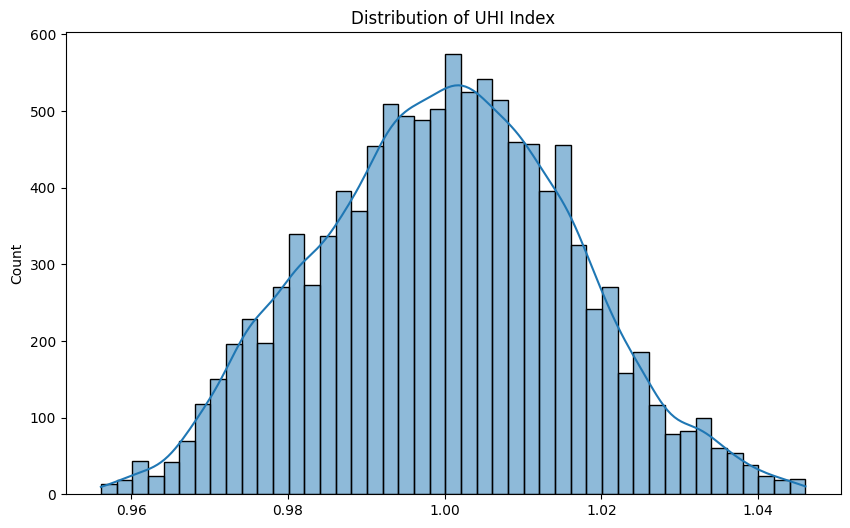

In [18]:
y = uhi_data['UHI Index'].values
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of UHI Index')
plt.show()

### Feature Selection 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [19]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

In [20]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

joblib.dump(sc, './models/scaler.pkl')

['./models/scaler.pkl']

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [21]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [22]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [23]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9935672119050832

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [24]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [25]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.9621813442539442

## Random Forest Optimization

Feature selection using Random Forest

In [26]:
from sklearn.feature_selection import SelectFromModel

# 1. Use a more robust feature selection approach
feature_selector = RandomForestRegressor(n_estimators=400, random_state=42, 
                                         max_features='sqrt', bootstrap=True,
                                         oob_score=True)  # More robust with OOB scoring
feature_selector.fit(X_train, y_train)

# 2. Get feature importances and sort them
importances = feature_selector.feature_importances_
indices = np.argsort(importances)[::-1]

# 4. Use a lower threshold to retain more features (50% of mean)
selector = SelectFromModel(feature_selector, threshold=0.5*np.mean(importances))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# 5. Calculate cumulative importance
cumulative_importance = np.cumsum(importances[indices])
top_n_features = np.argmax(cumulative_importance >= 0.80) + 1  # Target 90% importance coverage

print(f"Selected {X_train_selected.shape[1]} out of {X_train.shape[1]} features")
print(f"Percentage of information retained: {cumulative_importance[X_train_selected.shape[1]-1]*100:.2f}%")
print(f"Number of features needed for 80% information: {top_n_features}")

# 6. Save the model
joblib.dump(selector, 'models/selector.pkl')

Selected 434 out of 632 features
Percentage of information retained: 87.53%
Number of features needed for 80% information: 347


['models/selector.pkl']


1. Evaluating a diverse set of models with optimized parameters...
ExtraTrees - Train R²: 0.9978, Test R²: 0.9698, Test RMSE: 0.002802, Test MAE: 0.001906
CatBoost - Train R²: 0.9354, Test R²: 0.9117, Test RMSE: 0.004792, Test MAE: 0.003719

Models ranked by Test R²:
1. ExtraTrees - Test R²: 0.9698, RMSE: 0.002802, MAE: 0.001906
2. CatBoost - Test R²: 0.9117, RMSE: 0.004792, MAE: 0.003719


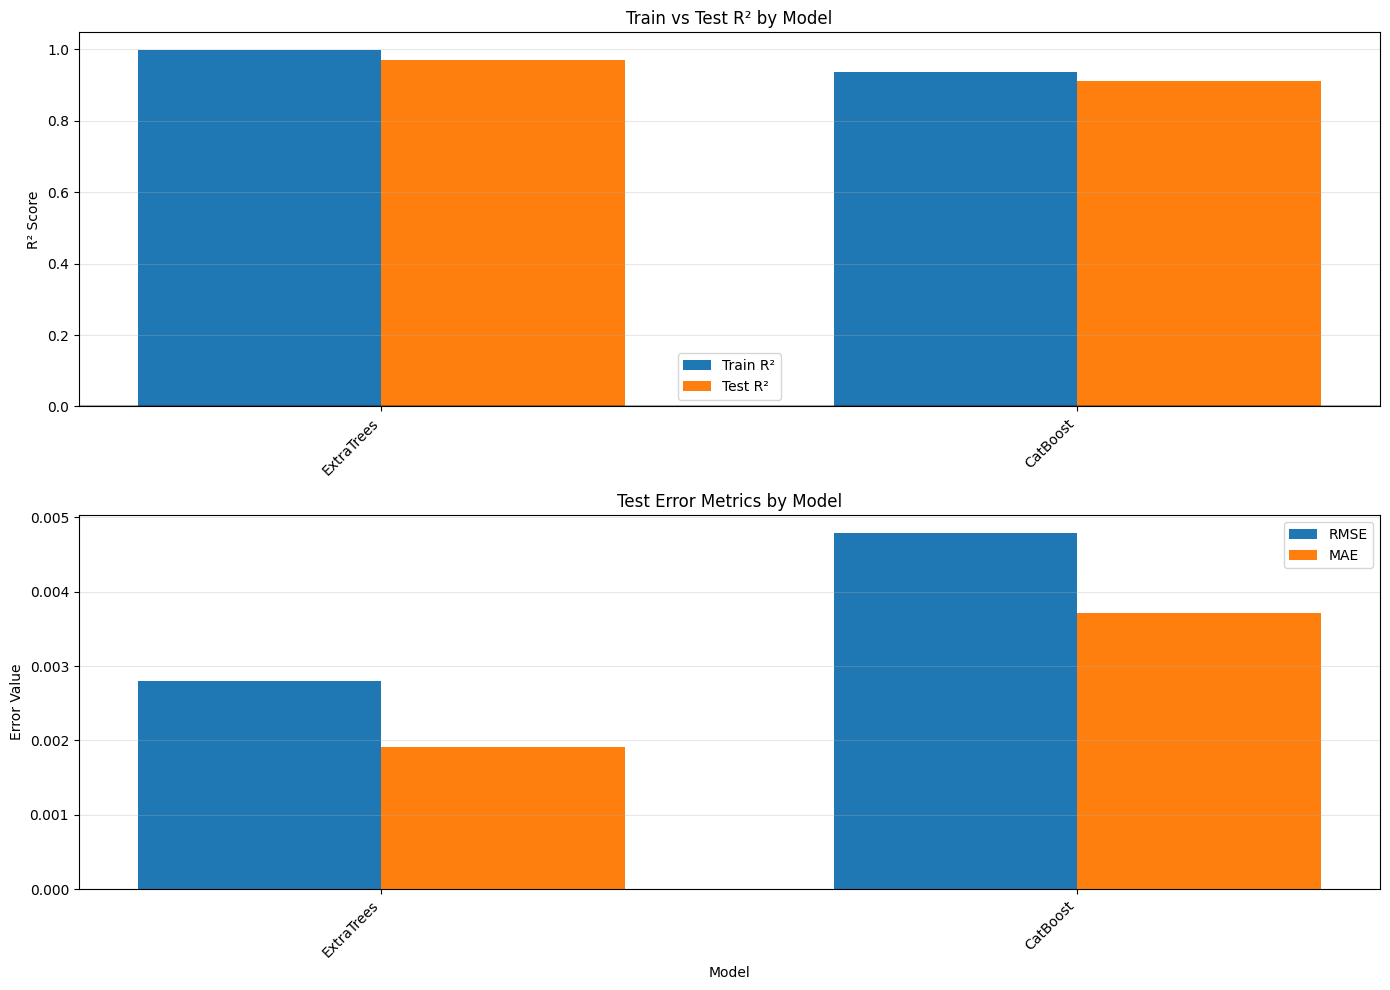


Top 3 Models:
1. ExtraTrees
   - Train R²: 0.9978, Test R²: 0.9698
   - Test RMSE: 0.002802, Test MAE: 0.001906
   - Gap (Train R² - Test R²): 0.0280
2. CatBoost
   - Train R²: 0.9354, Test R²: 0.9117
   - Test RMSE: 0.004792, Test MAE: 0.003719
   - Gap (Train R² - Test R²): 0.0237


In [ ]:
# Function to evaluate and store model results
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mae = mean_absolute_error(y_test, test_preds)
    
    print(f"{model_name} - Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.6f}, Test MAE: {test_mae:.6f}")
    
    return {
        'model': model,
        'train_preds': train_preds,
        'test_preds': test_preds,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae
    }

# 1. Define additional models to try with sensible parameters
print("\n1. Evaluating a diverse set of models with optimized parameters...")

# List of models to try with improved parameters
models_to_try = {
    # Best model from previous analysis 
    "RandomForest": RandomForestRegressor(
        n_estimators=434, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        max_features=0.5, 
        max_depth=None, 
        bootstrap=False, 
        random_state=42
    ),
    
    # Additional tree-based models with tuned parameters
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=0.5,
        subsample=0.8,
        random_state=42
    ),
    
    "ExtraTrees": ExtraTreesRegressor(
        n_estimators=400,
        min_samples_split=3,
        min_samples_leaf=1,
        max_features='log2',
        max_depth=None,
        bootstrap=False,
        random_state=42
    ),
    
    # Linear models with appropriate regularization
    "ElasticNet": ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        max_iter=2000,
        tol=1e-4,
        random_state=42
    ),
    
    "Ridge": Ridge(
        alpha=1.0,
        max_iter=2000,
        tol=1e-4,
        random_state=42
    ),
    
    # Support Vector Regression with tuned parameters
    "SVR": SVR(
        C=10.0,
        epsilon=0.1,
        kernel='rbf',
        gamma='scale'
    ),
    
    # K-Nearest Neighbors with tuned parameters
    "KNN": KNeighborsRegressor(
        n_neighbors=7,
        weights='distance',
        p=2,
        algorithm='auto'
    ),
    
    # Advanced boosting models with sensible parameters
    "XGBoost": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=1,
        random_state=42
    ),
    
    "LightGBM": LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=1,
        random_state=42
    ),
    
    "CatBoost": CatBoostRegressor(
        iterations=400,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        random_strength=0.1,
        bagging_temperature=1,
        random_state=42,
        verbose=0
    )
}

# Container for model results
model_results = {}

# Evaluate each model with optimized parameters
for model_name, model in models_to_try.items():
    try:
        model_results[model_name] = evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test, model_name)
    except Exception as e:
        print(f"Error with {model_name}: {e}")

# Find the best performing models
top_models = sorted(model_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)
print("\nModels ranked by Test R²:")
for i, (model_name, results) in enumerate(top_models):
    print(f"{i+1}. {model_name} - Test R²: {results['test_r2']:.4f}, RMSE: {results['test_rmse']:.6f}, MAE: {results['test_mae']:.6f}")

# Get the best model (first in the sorted list)
best_model_name, best_model_results = top_models[0]
best_model = models_to_try[best_model_name]  # Use models_to_try instead of models

# Save the best model
joblib.dump(best_model, 'models/final_model.pkl')

# Visualize model performance
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(14, 10))

# Plot R² scores
plt.subplot(2, 1, 1)
model_names = [name for name, _ in top_models]
test_r2_scores = [results['test_r2'] for _, results in top_models]
train_r2_scores = [results['train_r2'] for _, results in top_models]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, train_r2_scores, width, label='Train R²')
plt.bar(x + width/2, test_r2_scores, width, label='Test R²')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.ylabel('R² Score')
plt.title('Train vs Test R² by Model')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Plot error metrics
plt.subplot(2, 1, 2)
test_rmse_scores = [results['test_rmse'] for _, results in top_models]
test_mae_scores = [results['test_mae'] for _, results in top_models]

bar_width = 0.35
index = np.arange(len(model_names))

plt.bar(index - bar_width/2, test_rmse_scores, bar_width, label='RMSE')
plt.bar(index + bar_width/2, test_mae_scores, bar_width, label='MAE')
plt.xlabel('Model')
plt.ylabel('Error Value')
plt.title('Test Error Metrics by Model')
plt.xticks(index, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print the top 3 models with detailed information
print("\nTop 3 Models:")
for i, (model_name, results) in enumerate(top_models[:3]):
    print(f"{i+1}. {model_name}")
    print(f"   - Train R²: {results['train_r2']:.4f}, Test R²: {results['test_r2']:.4f}")
    print(f"   - Test RMSE: {results['test_rmse']:.6f}, Test MAE: {results['test_mae']:.6f}")
    print(f"   - Gap (Train R² - Test R²): {results['train_r2'] - results['test_r2']:.4f}")

Starting ExtraTrees optimization and ensemble exploration...

1. Optimizing ExtraTrees hyperparameters with focused RandomizedSearchCV...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best ExtraTrees Parameters: {'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Best CV Score (R²): 0.9666

2. Evaluating optimized ExtraTrees model...
Optimized ExtraTrees - Train R²: 0.9978, Test R²: 0.9698
Optimized ExtraTrees - Test RMSE: 0.002802, Test MAE: 0.001906

3. Creating and evaluating ensemble model...
Ensemble - Train R²: 0.9964, Test R²: 0.9680
Ensemble - Test RMSE: 0.002886, Test MAE: 0.002025

## Model Evaluation

Training Set - R²: 0.9978, RMSE: 0.0008
Test Set - R²: 0.9698, RMSE: 0.0028
Overfitting Gap (Train R² - Test R²): 0.0280


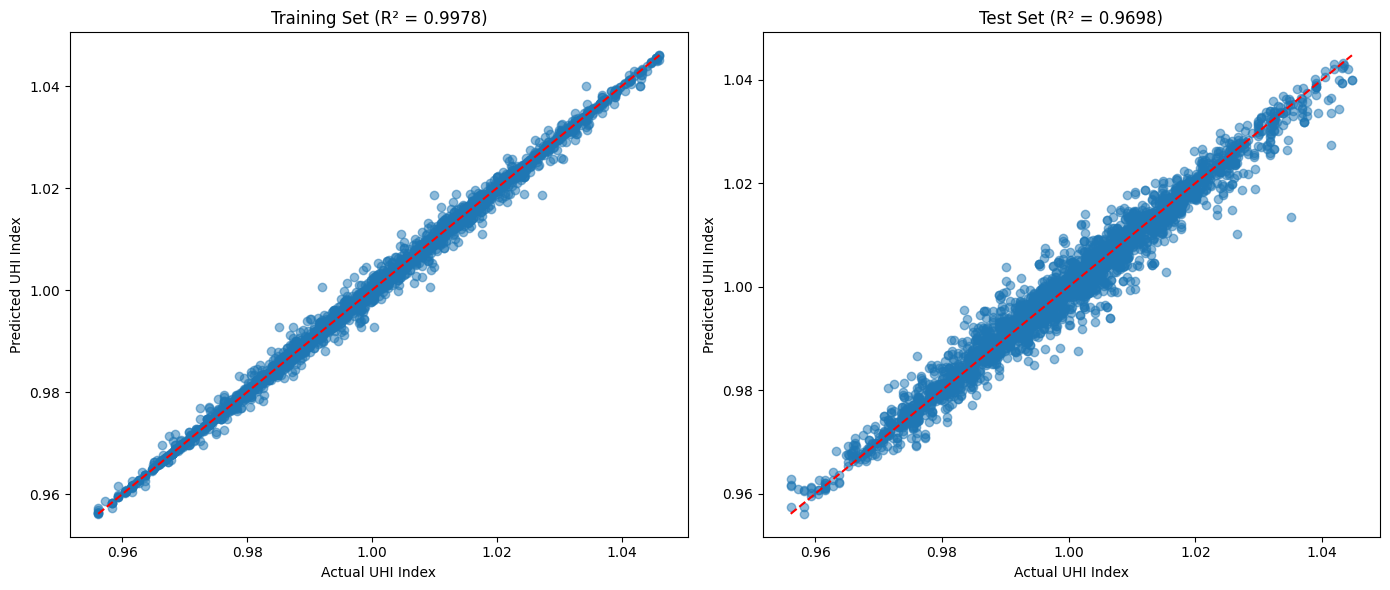

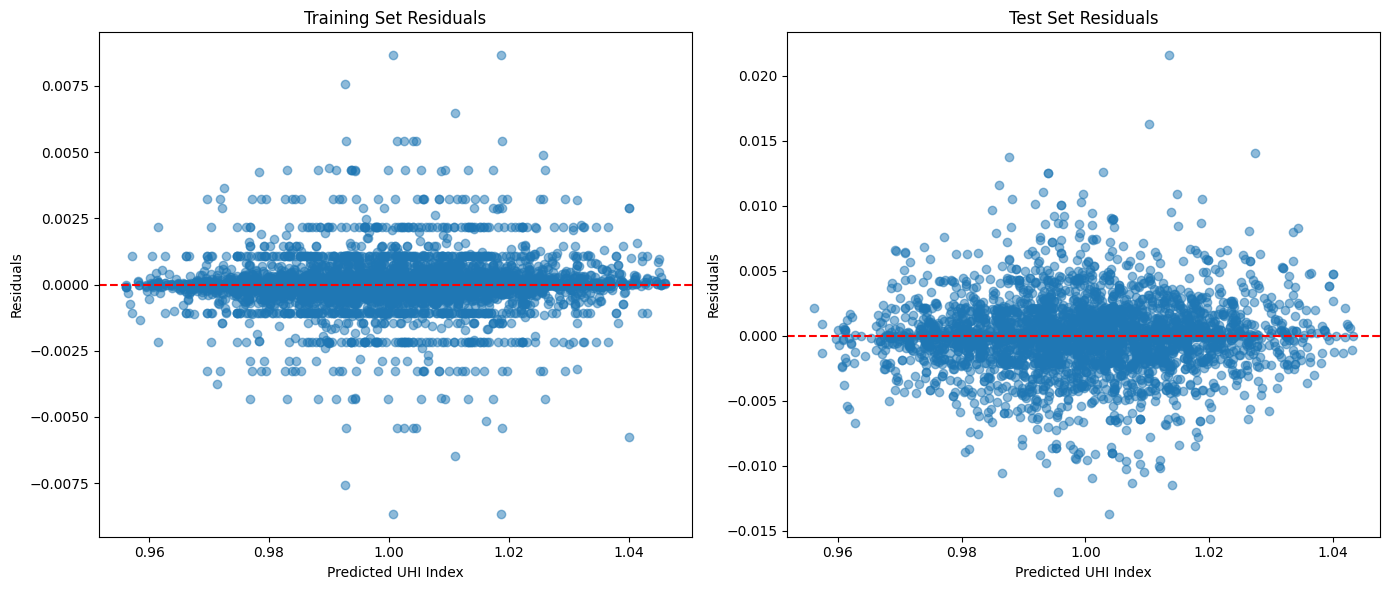

In [43]:
# 1. Load the saved models and transformers
model = joblib.load('models/final_model.pkl')  # Random Forest with Interactions
scaler = joblib.load('models/scaler.pkl')
selector = joblib.load('models/selector.pkl')

X_train_selected = selector.transform(X_train) # X_train is the scaled data
X_test_selected = selector.transform(X_test) # X_test is the scaled data

# 4. Make predictions on both sets
train_predictions = model.predict(X_train_selected)
test_predictions = model.predict(X_test_selected)

# 5. Evaluate metrics for both sets
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Training Set - R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
print(f"Test Set - R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
print(f"Overfitting Gap (Train R² - Test R²): {train_r2 - test_r2:.4f}")

# 6. Optional: Visualize predictions vs actuals for both sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training set plot
ax1.scatter(y_train, train_predictions, alpha=0.5)
ax1.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
ax1.set_xlabel('Actual UHI Index')
ax1.set_ylabel('Predicted UHI Index')
ax1.set_title(f'Training Set (R² = {train_r2:.4f})')

# Test set plot
ax2.scatter(y_test, test_predictions, alpha=0.5)
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
ax2.set_xlabel('Actual UHI Index')
ax2.set_ylabel('Predicted UHI Index')
ax2.set_title(f'Test Set (R² = {test_r2:.4f})')

plt.tight_layout()
plt.savefig('results/train_test_predictions.png')
plt.show()

# 7. Optional: Create a residual plot for both sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training residuals
train_residuals = y_train - train_predictions
ax1.scatter(train_predictions, train_residuals, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted UHI Index')
ax1.set_ylabel('Residuals')
ax1.set_title('Training Set Residuals')

# Test residuals
test_residuals = y_test - test_predictions
ax2.scatter(test_predictions, test_residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted UHI Index')
ax2.set_ylabel('Residuals')
ax2.set_title('Test Set Residuals')

plt.tight_layout()
plt.savefig('results/train_test_residuals.png')
plt.show()

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [44]:
#Reading the coordinates for the submission
test_file = pd.read_csv('../Submission_template_UHI2025-v2.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [45]:
# Create features at multiple buffer distances
buffer_distances = [250, 500, 1000]
multi_scale_features = []

for buffer in buffer_distances:
    print(f"Processing buffer distance: {buffer}m")
    buffer_data = map_satellite_data_with_buffer(
        tiff_path='../data/S2_sample.tiff',
        csv_path='../Submission_template_UHI2025-v2.csv',
        buffer_radius=buffer,
        adaptive_weighting=True,
        outlier_threshold=2.5,
        drop_invalid=False,
        handle_out_of_bounds='knn'
    )
    
    # Extract coordinates for joining
    coords = buffer_data[['Longitude', 'Latitude']].copy()
    
    # Drop coordinate columns and add suffix to remaining columns
    buffer_features = buffer_data.drop(columns=['Longitude', 'Latitude', 'buffer_radius_m', 'pixels_used', 'weighting', 'stddev', 'outliers_removed'])
    buffer_features = buffer_features.add_suffix(f'_buffer{buffer}m')
    
    # Add coordinates back for joining
    buffer_features = pd.concat([coords, buffer_features], axis=1)
    
    multi_scale_features.append(buffer_features)

# Initialize the combined dataframe with the first buffer distance data
val_data = multi_scale_features[0]

# Join each subsequent dataframe on coordinates
for i in range(1, len(multi_scale_features)):
    val_data = pd.merge(
        val_data, 
        multi_scale_features[i],
        on=['Longitude', 'Latitude'],
        how='inner'
    )

print(f"Final combined data shape: {val_data.shape}")

Processing buffer distance: 250m


Processing locations: 100%|██████████| 1040/1040 [00:16<00:00, 64.55it/s]


Interpolating values for 4 out-of-bounds points...
Handled 4 out-of-bounds points using 'knn' method.
Processing buffer distance: 500m


Processing locations: 100%|██████████| 1040/1040 [00:19<00:00, 54.12it/s]


Interpolating values for 4 out-of-bounds points...
Handled 4 out-of-bounds points using 'knn' method.
Processing buffer distance: 1000m


Processing locations: 100%|██████████| 1040/1040 [00:27<00:00, 37.59it/s]


Interpolating values for 4 out-of-bounds points...
Handled 4 out-of-bounds points using 'knn' method.
Final combined data shape: (1040, 554)


In [46]:
val_data = spatial_join_uhi_features(buildings_gdf, val_data, 
                                    max_distance=500, 
                                    weight_by_distance=True,
                                    use_voronoi=True, 
                                    interpolate_features=True)

Starting enhanced spatial join with 9436 buildings and 1040 inference points
Converting to projected CRS for accurate distance calculations...
Identified 85 UHI feature columns to transfer
Finding points within building polygons...
Found 48 points inside building polygons
Processing 992 points outside building footprints...
Using Voronoi tessellation for spatial allocation...
Voronoi allocation found 992 points within 500m of a building centroid
Performing post-processing to fill remaining NaN values...
Filling NaN values for 11 columns with available data
Spatial join complete. Result has 1040 rows with UHI features


In [47]:
val_data.head()

,Longitude,Latitude,B01_buffer250m,B02_buffer250m,B03_buffer250m,B04_buffer250m,B05_buffer250m,B06_buffer250m,B07_buffer250m,B08_buffer250m,...,wind_exposure_inv,street_porosity_100m_inv,ventilation_restriction_index,building_morphology_index,building_density_per_km2_500m_norm,built_up_ratio_500m_norm,estimated_impervious_ratio_500m_norm,urban_density_index,uhi_vulnerability_index,uhi_vulnerability_normalized
0,-73.971665,40.788763,1078.540177,1037.696705,1131.670107,1188.341782,1352.119874,1562.333723,1630.944250,1577.924735,...,-56.851887,0.131571,-28.360158,0.491922,0.151420,0.744360,0.695018,0.530266,-9.112657,0.882495
1,-73.971928,40.788875,1079.711649,1047.361331,1149.455842,1209.285150,1377.864620,1602.942165,1674.296282,1647.060938,...,-56.851887,0.131571,-28.360158,0.491922,0.151420,0.744360,0.695018,0.530266,-9.112657,0.882495
2,-73.967080,40.789080,1461.552480,1451.628788,1601.735962,1791.174377,1980.298814,2092.969279,2137.623423,2079.633057,...,-191.248174,0.000000,-95.624087,0.637568,0.107256,0.479292,0.436535,0.341028,-31.548497,0.614443
3,-73.972550,40.789082,1047.450466,1001.281241,1110.351645,1158.537793,1332.135832,1612.394409,1706.011623,1677.222231,...,-70.183822,0.093303,-35.045259,0.490340,0.160883,0.807610,0.758042,0.575511,-11.326469,0.856046
4,-73.969697,40.787953,1089.366866,1047.959793,1105.692185,1147.957041,1288.870764,1369.510638,1411.474077,1344.136130,...,-132.950792,0.000000,-66.475396,0.506552,0.104101,0.597946,0.543610,0.415219,-21.851208,0.730301


In [48]:
exclusion_list = ['Longitude', 'Latitude', 'datetime', 'ventilation_potential',
    'street_canyon_potential_100m_std',
    'building_alignment_100m_std',
    'building_alignment_100m',
    'street_canyon_potential_100m']

feature_columns = [col for col in val_data.columns if col not in exclusion_list]

submission_val_data = val_data.loc[:, feature_columns]
submission_val_data.head()

,B01_buffer250m,B02_buffer250m,B03_buffer250m,B04_buffer250m,B05_buffer250m,B06_buffer250m,B07_buffer250m,B08_buffer250m,B8A_buffer250m,B11_buffer250m,...,wind_exposure_inv,street_porosity_100m_inv,ventilation_restriction_index,building_morphology_index,building_density_per_km2_500m_norm,built_up_ratio_500m_norm,estimated_impervious_ratio_500m_norm,urban_density_index,uhi_vulnerability_index,uhi_vulnerability_normalized
0,1078.540177,1037.696705,1131.670107,1188.341782,1352.119874,1562.333723,1630.944250,1577.924735,1654.438644,1727.742124,...,-56.851887,0.131571,-28.360158,0.491922,0.151420,0.744360,0.695018,0.530266,-9.112657,0.882495
1,1079.711649,1047.361331,1149.455842,1209.285150,1377.864620,1602.942165,1674.296282,1647.060938,1715.087651,1774.593543,...,-56.851887,0.131571,-28.360158,0.491922,0.151420,0.744360,0.695018,0.530266,-9.112657,0.882495
2,1461.552480,1451.628788,1601.735962,1791.174377,1980.298814,2092.969279,2137.623423,2079.633057,2169.917388,2528.388148,...,-191.248174,0.000000,-95.624087,0.637568,0.107256,0.479292,0.436535,0.341028,-31.548497,0.614443
3,1047.450466,1001.281241,1110.351645,1158.537793,1332.135832,1612.394409,1706.011623,1677.222231,1757.630509,1726.211603,...,-70.183822,0.093303,-35.045259,0.490340,0.160883,0.807610,0.758042,0.575511,-11.326469,0.856046
4,1089.366866,1047.959793,1105.692185,1147.957041,1288.870764,1369.510638,1411.474077,1344.136130,1398.399685,1559.599921,...,-132.950792,0.000000,-66.475396,0.506552,0.104101,0.597946,0.543610,0.415219,-21.851208,0.730301


In [49]:
scaler = joblib.load('models/scaler.pkl')
model = joblib.load('models/final_model.pkl')
selector = joblib.load('models/selector.pkl')

# Feature Scaling 
submission_val_data = submission_val_data.values
scaled_submission_data = scaler.transform(submission_val_data)
transformed_submission_data = selector.transform(scaled_submission_data)

In [50]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [51]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [52]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.963465
1,-73.971928,40.788875,0.964438
2,-73.967080,40.789080,0.962630
3,-73.972550,40.789082,0.963545
4,-73.969697,40.787953,0.959637


In [53]:
#Dumping the predictions into a csv file.
submission_df.to_csv("../submissions/submission.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.